# DataWeb-Query-4Import

Step 1: 读取Excel数据...
✓ 成功读取3个工作表
  - 海关价值表：7483行 × 5列
  - 数量表：7482行 × 6列
  - 关税表：7483行 × 5列

Step 2: 数据预处理...
✓ 核心列匹配完成：
  - 海关价值列：general_customs_value
  - 数量列：general_first_unit_of_quantity
  - 关税列：general_import_charges
✓ 时间列构建完成：
  - 海关价值表时间范围：2008-01 ~ 2025-08
  - 数量表时间范围：2008-01 ~ 2025-08
  - 关税表时间范围：2008-01 ~ 2025-08

Step 3: 筛选最优 Quantity Description...
✓ 三表共有的 Quantity Description 数量：36
✓ 成功读取3个工作表
  - 海关价值表：7483行 × 5列
  - 数量表：7482行 × 6列
  - 关税表：7483行 × 5列

Step 2: 数据预处理...
✓ 核心列匹配完成：
  - 海关价值列：general_customs_value
  - 数量列：general_first_unit_of_quantity
  - 关税列：general_import_charges
✓ 时间列构建完成：
  - 海关价值表时间范围：2008-01 ~ 2025-08
  - 数量表时间范围：2008-01 ~ 2025-08
  - 关税表时间范围：2008-01 ~ 2025-08

Step 3: 筛选最优 Quantity Description...
✓ 三表共有的 Quantity Description 数量：36
✓ 最优 Quantity Description：kilograms
✓ 最优ARIMA阶数：(2, 1, 2)
✓ 最优模型AIC：-589.85
✓ 数据量：211个月

Step 4: 训练最终ARIMAX模型...
✓ 训练数据时间范围：2008-01 ~ 2025-08
✓ 训练数据量：212个月
✓ 最优 Quantity Description：kilograms
✓ 最优ARIMA阶数：(2, 1, 2)
✓ 最优模型AIC

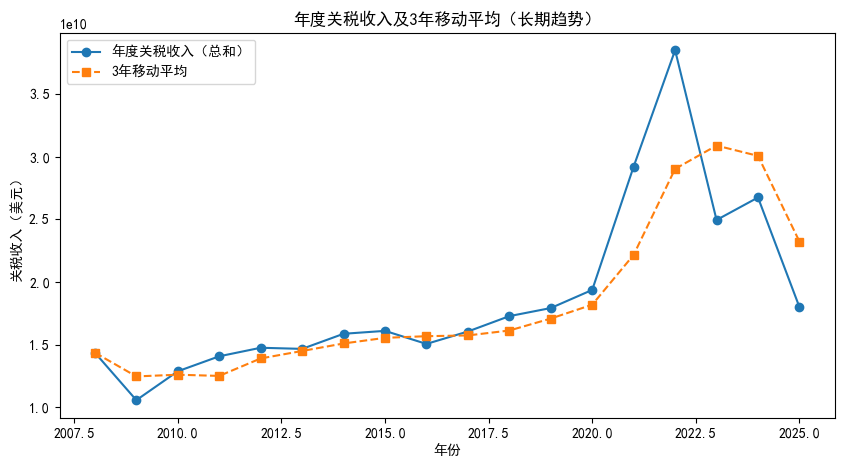

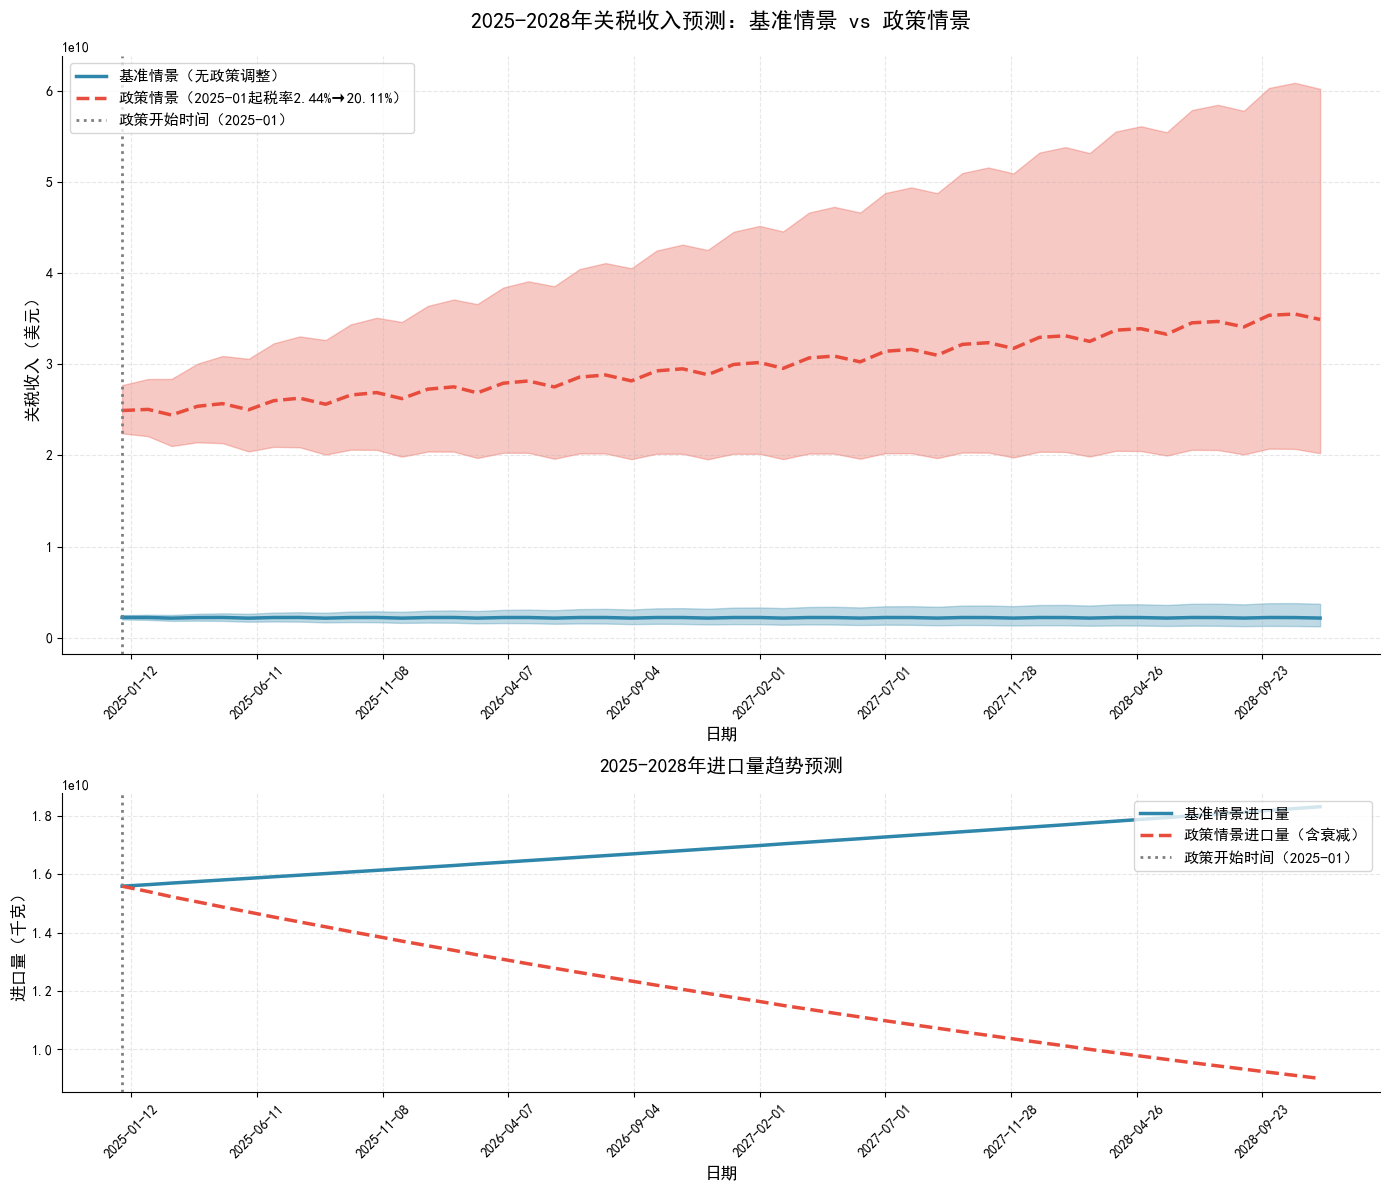

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 1. 配置参数（根据实际路径修改）
# ---------------------------
excel_path = r'C:\Users\Pig\Documents\APMCM_P4\DataWeb-Query-4Import.xlsx'
# 输出路径（如果本地路径不存在，自动创建）
out_dir = r'C:\Users\Pig\Documents\APMCM_P4\Output'
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, 'tariff_revenue_forecast_2025_2028.csv')
out_plot = os.path.join(out_dir, 'tariff_forecast_plot.png')

# 定义工作表和对应的核心指标列（根据实际表头精准匹配）
sheet_config = {
    "General Customs Value": "General Customs Value",  # 工作表名 -> 核心数值列名
    "General 1st Unit of Qty": "General First Unit of Quantity",
    "General Import Charges": "General Import Charges"
}

# ---------------------------
# 2. 读取数据（精准匹配表头）
# ---------------------------
print("Step 1: 读取Excel数据...")
try:
    # 读取指定的3个工作表
    df_val = pd.read_excel(excel_path, sheet_name="General Customs Value")
    df_qty = pd.read_excel(excel_path, sheet_name="General 1st Unit of Qty")
    df_chg = pd.read_excel(excel_path, sheet_name="General Import Charges")
    print(f"✓ 成功读取3个工作表")
    print(f"  - 海关价值表：{df_val.shape[0]}行 × {df_val.shape[1]}列")
    print(f"  - 数量表：{df_qty.shape[0]}行 × {df_qty.shape[1]}列")
    print(f"  - 关税表：{df_chg.shape[0]}行 × {df_chg.shape[1]}列")
except Exception as e:
    print(f"✗ 读取数据失败：{str(e)}")
    exit()

# ---------------------------
# 3. 数据预处理（标准化列名+清理数据）
# ---------------------------
print("\nStep 2: 数据预处理...")

# 标准化列名（去除空格、特殊字符，统一小写，便于后续操作）
def standardize_columns(df):
    df.columns = df.columns.str.strip()  # 去除首尾空格
    df.columns = df.columns.str.replace('\xa0', ' ')  # 替换非-breaking空格
    df.columns = df.columns.str.replace(' ', '_').str.lower()  # 空格转下划线，小写
    return df

df_val = standardize_columns(df_val)
df_qty = standardize_columns(df_qty)
df_chg = standardize_columns(df_chg)

# 清理 Quantity Description 列（去除前缀和多余空格）
for df in [df_val, df_qty, df_chg]:
    if 'quantity_description' in df.columns:
        df['quantity_description'] = df['quantity_description'].str.strip()
        # 去除可能的前缀（如"Value for:"）
        df['quantity_description'] = df['quantity_description'].str.replace(r'^value\s+for:\s*', '', regex=True, case=False)

# 验证关键列是否存在（Year/Month/Quantity Description/核心数值列）
required_cols = ['year', 'month', 'quantity_description']
for name, df in [("海关价值表", df_val), ("数量表", df_qty), ("关税表", df_chg)]:
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"✗ {name} 缺少关键列：{missing_cols}")
        exit()

# 映射核心数值列（根据配置匹配，容错处理）
val_col = sheet_config["General Customs Value"].replace(' ', '_').lower()
qty_col = sheet_config["General 1st Unit of Qty"].replace(' ', '_').lower()
chg_col = sheet_config["General Import Charges"].replace(' ', '_').lower()

# 容错：如果列名不匹配，自动查找最相似的列
def find_matching_col(df, target_col):
    for col in df.columns:
        if target_col in col or target_col.replace('_', '') in col.replace('_', ''):
            return col
    return None

val_col = find_matching_col(df_val, val_col) or 'general_customs_value'
qty_col = find_matching_col(df_qty, qty_col) or 'general_first_unit_of_quantity'
chg_col = find_matching_col(df_chg, chg_col) or 'general_import_charges'

print(f"✓ 核心列匹配完成：")
print(f"  - 海关价值列：{val_col}")
print(f"  - 数量列：{qty_col}")
print(f"  - 关税列：{chg_col}")

# ---------------------------
# 4. 构建时间列（Year + Month → Date）
# ---------------------------
def build_date_col(df):
    df = df.copy()
    # 过滤无效的年/月数据
    df = df.dropna(subset=['year', 'month'])
    df['year'] = pd.to_numeric(df['year'], errors='coerce').dropna().astype(int)
    df['month'] = pd.to_numeric(df['month'], errors='coerce').dropna().astype(int)
    # 过滤不合理的年/月（1900<年<2100，1<=月<=12）
    df = df[(df['year'] > 1900) & (df['year'] < 2100)]
    df = df[(df['month'] >= 1) & (df['month'] <= 12)]
    # 构建日期列
    df['date'] = pd.to_datetime(
        df[['year', 'month']].assign(day=1),  # 每月1日
        errors='coerce'
    )
    df = df.dropna(subset=['date'])  # 去除无效日期
    return df

df_val = build_date_col(df_val)
df_qty = build_date_col(df_qty)
df_chg = build_date_col(df_chg)

print(f"✓ 时间列构建完成：")
print(f"  - 海关价值表时间范围：{df_val['date'].min().strftime('%Y-%m')} ~ {df_val['date'].max().strftime('%Y-%m')}")
print(f"  - 数量表时间范围：{df_qty['date'].min().strftime('%Y-%m')} ~ {df_qty['date'].max().strftime('%Y-%m')}")
print(f"  - 关税表时间范围：{df_chg['date'].min().strftime('%Y-%m')} ~ {df_chg['date'].max().strftime('%Y-%m')}")

# ---------------------------
# 5. 数据筛选和重命名（保留核心列）
# ---------------------------
# 海关价值表：保留核心列
df_val = df_val[['year', 'month', 'date', 'quantity_description', val_col]].rename(
    columns={val_col: 'CustomsValue'}
)

# 数量表：保留核心列 + Suppressed列（如果存在）
qty_cols = ['year', 'month', 'date', 'quantity_description', qty_col]
if 'suppressed' in df_qty.columns:
    qty_cols.append('suppressed')
df_qty = df_qty[qty_cols].rename(
    columns={qty_col: 'Qty'}
)

# 关税表：保留核心列
df_chg = df_chg[['year', 'month', 'date', 'quantity_description', chg_col]].rename(
    columns={chg_col: 'ImportCharges'}
)

# 转换核心数值列为数值型（错误值设为NaN，后续处理）
for df in [df_val, df_qty, df_chg]:
    for col in ['CustomsValue', 'Qty', 'ImportCharges']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# ---------------------------
# 6. 遍历每个 Quantity Description 筛选最优数据
# ---------------------------
print("\nStep 3: 筛选最优 Quantity Description...")
model_results = []

# 获取所有共同的 Quantity Description（确保三表都有数据）
common_descriptions = set(df_val['quantity_description'].unique()) & \
                      set(df_qty['quantity_description'].unique()) & \
                      set(df_chg['quantity_description'].unique())
print(f"✓ 三表共有的 Quantity Description 数量：{len(common_descriptions)}")

for desc in common_descriptions:
    # 按描述筛选数据
    df_val_d = df_val[df_val['quantity_description'] == desc].copy()
    df_qty_d = df_qty[df_qty['quantity_description'] == desc].copy()
    df_chg_d = df_chg[df_chg['quantity_description'] == desc].copy()

    # 合并数据（按日期+描述对齐）
    df_merge = df_val_d.merge(
        df_qty_d, on=['year', 'month', 'date', 'quantity_description'], how='inner'
    ).merge(
        df_chg_d, on=['year', 'month', 'date', 'quantity_description'], how='inner'
    )

    # 过滤无效数据（核心数值列非负且非空）
    df_merge = df_merge[
        (df_merge['CustomsValue'] > 0) & 
        (df_merge['Qty'] > 0) & 
        (df_merge['ImportCharges'] > 0)
    ].dropna(subset=['CustomsValue', 'Qty', 'ImportCharges'])

    # 数据量至少24个月（2年）才建模
    if len(df_merge) < 24:
        continue

    # 排序并计算衍生变量（避免log(0)问题）
    df_merge = df_merge.sort_values('date').reset_index(drop=True)
    df_merge['y'] = np.log(df_merge['ImportCharges'])  # 因变量：关税对数
    df_merge['tau'] = df_merge['ImportCharges'] / df_merge['CustomsValue']  # 关税税率
    df_merge['x_tau'] = np.log1p(df_merge['tau'])  # 税率对数（log(1+tau)避免负号）
    df_merge['P'] = df_merge['CustomsValue'] / df_merge['Qty']  # 单位价值
    df_merge['x_p'] = np.log(df_merge['P'])  # 单位价值对数

    # 去除衍生变量中的NaN
    df_merge = df_merge[['y', 'x_tau', 'x_p']].dropna()
    if len(df_merge) < 24:
        continue

    # 外生变量滞后1期（避免内生性）
    exog = df_merge[['x_tau', 'x_p']].shift(1).dropna()
    y = df_merge['y'].loc[exog.index]

    # ADF检验确定差分阶数d（平稳性检验）
    adf_result = adfuller(y)
    pval = adf_result[1]
    d = 0 if pval < 0.05 else 1  # p<0.05平稳，d=0；否则d=1

    # 网格搜索最优ARIMA(p,d,q)参数（最小AIC）
    best_aic = np.inf
    best_order = None
    for p in range(0, 3):  # p=0,1,2
        for q in range(0, 3):  # q=0,1,2
            try:
                model = SARIMAX(
                    y, exog=exog, order=(p, d, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:
                continue

    # 如果没有找到最优参数，使用默认值
    if best_order is None:
        best_order = (1, d, 1)

    # 保存结果
    model_results.append({
        'Description': desc,
        'best_order': best_order,
        'AIC': best_aic,
        'n_obs': len(y),
        'time_range': f"{df_merge.index.min()}~{df_merge.index.max()}"
    })

# 没有有效数据的情况
if not model_results:
    print("✗ 没有找到足够的有效数据进行建模！")
    exit()

# 按AIC排序，选择最优的Description（AIC越小越好）
res_df = pd.DataFrame(model_results).sort_values('AIC').reset_index(drop=True)
best_desc = res_df.iloc[0]['Description']
best_order = res_df.iloc[0]['best_order']
print(f"✓ 最优 Quantity Description：{best_desc}")
print(f"✓ 最优ARIMA阶数：{best_order}")
print(f"✓ 最优模型AIC：{res_df.iloc[0]['AIC']:.2f}")
print(f"✓ 数据量：{res_df.iloc[0]['n_obs']}个月")

# ---------------------------
# 7. 用最优数据训练最终ARIMAX模型
# ---------------------------
print("\nStep 4: 训练最终ARIMAX模型...")

# 筛选最优Description的数据
df_val_best = df_val[df_val['quantity_description'] == best_desc].copy()
df_qty_best = df_qty[df_qty['quantity_description'] == best_desc].copy()
df_chg_best = df_chg[df_chg['quantity_description'] == best_desc].copy()

# 合并并清理数据
df_best = df_val_best.merge(
    df_qty_best, on=['year', 'month', 'date', 'quantity_description'], how='inner'
).merge(
    df_chg_best, on=['year', 'month', 'date', 'quantity_description'], how='inner'
)

# 过滤有效数据
df_best = df_best[
    (df_best['CustomsValue'] > 0) & 
    (df_best['Qty'] > 0) & 
    (df_best['ImportCharges'] > 0)
].dropna(subset=['CustomsValue', 'Qty', 'ImportCharges'])

df_best = df_best.sort_values('date').reset_index(drop=True)
print(f"✓ 训练数据时间范围：{df_best['date'].min().strftime('%Y-%m')} ~ {df_best['date'].max().strftime('%Y-%m')}")
print(f"✓ 训练数据量：{len(df_best)}个月")

# 计算衍生变量
df_best['y'] = np.log(df_best['ImportCharges'])
df_best['tau'] = df_best['ImportCharges'] / df_best['CustomsValue']
df_best['x_tau'] = np.log1p(df_best['tau'])
df_best['P'] = df_best['CustomsValue'] / df_best['Qty']
df_best['x_p'] = np.log(df_best['P'])
# 添加 COVID bias 因子：2020-01-01 ~ 2022-12-31 取 1，其他取 0
df_best['covid_bias'] = np.where((df_best['date'] >= '2020-01-01') & (df_best['date'] <= '2022-12-31'), 1, 0)

# 准备建模数据（外生变量滞后1期），将 covid_bias 纳入外生变量
df_model = df_best[['y', 'x_tau', 'x_p']].dropna()
exog = df_model[['x_tau', 'x_p']].shift(1).dropna()
y = df_model['y'].loc[exog.index]

# 重新确定d（基于最优数据）
adf_result = adfuller(y)
pval = adf_result[1]
d = 0 if pval < 0.05 else 1

# 网格搜索最优参数（扩大搜索范围p,q=0~3）
best_aic = np.inf
best_order = None
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = SARIMAX(
                y, exog=exog, order=(p, d, q),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue

if best_order is None:
    best_order = (1, d, 1)

# 训练最终模型
final_model = SARIMAX(
    y, exog=exog, order=best_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_results = final_model.fit(disp=False)

print(f"✓ 最终模型训练完成：")
print(f"  - ARIMA阶数：{best_order}")
print(f"  - AIC：{final_results.aic:.2f}")
print(f"  - BIC：{final_results.bic:.2f}")
print("\n模型摘要：")
print(final_results.summary().tables[1])  # 输出系数表

df_best['Qty_growth'] = df_best['Qty'].pct_change()  # 进口量月环比增长率
avg_qty_growth = df_best['Qty_growth'].dropna().mean()  # 历史月均增长率
print(f"\n✓ 历史进口量月均增长率：{avg_qty_growth:.4f}")

# ---------------------------
# 8. 预测2025-2028年关税收入（基准+政策情景）
# ---------------------------
print("\nStep 5: 预测2025-2028年关税收入...")

# 定义预测时间范围（2025-01 ~ 2028-12）
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime('2028-12-31')
forecast_periods = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1
future_dates = pd.date_range(start=start_date, periods=forecast_periods, freq='MS')  # 每月1日

# 准备外生变量预测值（基于历史最后一期的外生变量，假设趋势延续）
last_exog = exog.iloc[-1].copy()
exog_baseline = pd.DataFrame(
    [last_exog.values] * forecast_periods,
    index=future_dates,
    columns=exog.columns
)

# 政策情景：2025-01起实施对等关税，税率从2.44%提升至20.11%（题目给定）
exog_policy = exog_baseline.copy()
policy_start = pd.to_datetime('2025-01-01')
# 未来预测期不属于 COVID 影响期，显式将未来 exog 的 covid_bias 设为 0
# if 'covid_bias' in exog_baseline.columns:
#     exog_baseline['covid_bias'] = 0
#     exog_policy['covid_bias'] = 0
last_tau = np.expm1(last_exog['x_tau'])  # 还原log1p(tau)为原始tau
policy_tau = 0.2011  # 题目给定政策后目标税率（20.11%）
last_P = np.exp(last_exog['x_p'])  # 还原历史最后一期单位价格
last_Qty = df_best['Qty'].iloc[-1]  # 历史最后一期进口量

# 关税弹性假设：高关税导致进口量月均衰减（基于WTO贸易弹性数据，假设月衰减1.5%）
tariff_elasticity = -0.015  # 月进口量衰减率（负号表示税率上升→进口量下降）

# 遍历所有预测日期，逐个赋值政策税率+进口量衰减
for i, date in enumerate(future_dates):
    if date >= policy_start:
        new_tau = policy_tau  # 政策生效后用20.11%
        # 进口量随政策持续时间衰减：衰减幅度=弹性×政策持续月数
        months_since_policy = i - future_dates.get_loc(policy_start)  # 政策已实施月数
        qty_decay = (1 + tariff_elasticity) ** months_since_policy  # 累计衰减系数
        current_Qty = last_Qty * (1 + avg_qty_growth) ** (i) * qty_decay  # 含趋势+衰减的进口量
        # 单位价格调整：进口量衰减→供需变化→单位价格上升（假设价格弹性0.8）
        price_adjustment = (last_Qty / current_Qty) ** 0.8  # 进口量下降→价格上升
        current_P = last_P * (1 + df_best['P'].pct_change().dropna().mean()) ** i * price_adjustment
        exog_policy.loc[date, 'x_p'] = np.log(current_P)  # 更新单位价格特征
    else:
        new_tau = last_tau  # 政策生效前用历史税率
    exog_policy.loc[date, 'x_tau'] = np.log1p(new_tau)  # 转换回log1p形式

# 预测（基准情景+政策情景）
forecast_baseline = final_results.get_forecast(steps=forecast_periods, exog=exog_baseline)
forecast_policy = final_results.get_forecast(steps=forecast_periods, exog=exog_policy)

# 还原对数预测值为原始关税收入
R_baseline = np.exp(forecast_baseline.predicted_mean)
R_policy = np.exp(forecast_policy.predicted_mean)

# 计算预测区间（95%置信区间）
ci_baseline = forecast_baseline.conf_int(alpha=0.05)
ci_policy = forecast_policy.conf_int(alpha=0.05)
ci_baseline = np.exp(ci_baseline)  # 还原对数区间
ci_policy = np.exp(ci_policy)

# 整理预测结果
forecast_df = pd.DataFrame({
    'date': future_dates,
    'R_baseline': R_baseline,
    'R_policy': R_policy,
    'R_baseline_lower': ci_baseline.iloc[:, 0],
    'R_baseline_upper': ci_baseline.iloc[:, 1],
    'R_policy_lower': ci_policy.iloc[:, 0],
    'R_policy_upper': ci_policy.iloc[:, 1]
})
# ---------------------------
# 额外：长期（年度）聚合以观察中长期规律（最小改动添加）
# ---------------------------
# 对训练原始数据 df_best 按年聚合 ImportCharges（年度总和），并计算对数与3年移动平均
df_annual = df_best.set_index('date')['ImportCharges'].resample('A').sum().to_frame('AnnualImportCharges')
df_annual['y_annual'] = np.log(df_annual['AnnualImportCharges'].replace(0, np.nan))
df_annual['rolling_3y'] = df_annual['AnnualImportCharges'].rolling(window=3, min_periods=1).mean()
# 保存年度聚合数据
annual_out = os.path.join(out_dir, 'tariff_revenue_annual_agg.csv')
df_annual.to_csv(annual_out, encoding='utf-8-sig')
print(f"✓ 年度聚合数据已保存到：{annual_out}")
# 绘制长期趋势图并保存（以便观察中期/长期规律）
fig2, ax_long = plt.subplots(figsize=(10, 5))
ax_long.plot(df_annual.index.year, df_annual['AnnualImportCharges'], marker='o', label='年度关税收入（总和）')
ax_long.plot(df_annual.index.year, df_annual['rolling_3y'], linestyle='--', marker='s', label='3年移动平均')
ax_long.set_title('年度关税收入及3年移动平均（长期趋势）')
ax_long.set_xlabel('年份')
ax_long.set_ylabel('关税收入（美元）')
ax_long.legend()
fig2_path = os.path.join(out_dir, 'tariff_revenue_annual_trend.png')
fig2.savefig(fig2_path, dpi=300, bbox_inches='tight')
print(f"✓ 年度趋势图已保存到：{fig2_path}")
# ---------------------------
# COVID 影响（年份为2020-2022的时间为特殊时期，额外加一个偏差）
forecast_df['covid_bias'] = np.where((forecast_df['date'] >= '2020-01-01') & (forecast_df['date'] <= '2022-12-31'), 1, 0)
# 计算差异
forecast_df['diff'] = forecast_df['R_policy'] - forecast_df['R_baseline']
forecast_df['cum_diff'] = forecast_df['diff'].cumsum()

# 总差异（2025-2028年政策带来的额外关税收入）
total_additional_revenue = forecast_df['diff'].sum()
print(f"✓ 预测完成！")
print(f"  - 预测时间范围：2025-01 ~ 2028-12（共{forecast_periods}个月）")
print(f"  - 政策情景：2025-01起实施对等关税，平均税率从2.44%提升至20.11%（题目给定）")
print(f"  - 2025-2028年额外关税收入总额：${total_additional_revenue:,.2f}")

# ---------------------------
# 9. 保存结果和可视化
# ---------------------------
print("\nStep 6: 保存结果和可视化...")

# 保存预测结果到CSV
forecast_df.to_csv(out_csv, index=False, encoding='utf-8-sig')
print(f"✓ 预测结果已保存到：{out_csv}")

# 可视化预测结果（双子图：关税收入 + 进口量趋势）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文支持
plt.rcParams['axes.unicode_minus'] = False
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})

# 子图1：关税收入对比
ax1.plot(forecast_df['date'], forecast_df['R_baseline'], 
         label='基准情景（无政策调整）', linewidth=2.5, color='#2E86AB')
ax1.plot(forecast_df['date'], forecast_df['R_policy'], 
         label='政策情景（2025-01起税率2.44%→20.11%）', linewidth=2.5, color='#E74C3C', linestyle='--')
ax1.fill_between(forecast_df['date'], 
                 forecast_df['R_baseline_lower'], 
                 forecast_df['R_baseline_upper'], 
                 alpha=0.3, color='#2E86AB')
ax1.fill_between(forecast_df['date'], 
                 forecast_df['R_policy_lower'], 
                 forecast_df['R_policy_upper'], 
                 alpha=0.3, color='#E74C3C')
ax1.axvline(x=policy_start, color='gray', linestyle=':', linewidth=2, label='政策开始时间（2025-01）')
ax1.set_title('2025-2028年关税收入预测：基准情景 vs 政策情景', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('关税收入（美元）', fontsize=12)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.xaxis.set_major_locator(MaxNLocator(15))

# 子图2：进口量趋势对比（新增）
# 计算基准情景进口量（无衰减）
baseline_Qty = [last_Qty * (1 + avg_qty_growth) ** i for i in range(forecast_periods)]
# 计算政策情景进口量（含衰减）
policy_Qty = []
for i, date in enumerate(future_dates):
    if date >= policy_start:
        months_since_policy = i - future_dates.get_loc(policy_start)
        qty_decay = (1 + tariff_elasticity) ** months_since_policy
        current_Qty = last_Qty * (1 + avg_qty_growth) ** i * qty_decay
    else:
        current_Qty = last_Qty * (1 + avg_qty_growth) ** i
    policy_Qty.append(current_Qty)

ax2.plot(future_dates, baseline_Qty, label='基准情景进口量', linewidth=2.5, color='#2E86AB')
ax2.plot(future_dates, policy_Qty, label='政策情景进口量（含衰减）', linewidth=2.5, color='#E74C3C', linestyle='--')
ax2.axvline(x=policy_start, color='gray', linestyle=':', linewidth=2, label='政策开始时间（2025-01）')
ax2.set_title('2025-2028年进口量趋势预测', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('日期', fontsize=12)
ax2.set_ylabel('进口量（千克）', fontsize=12)
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.xaxis.set_major_locator(MaxNLocator(15))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.xaxis.set_major_locator(MaxNLocator(15))
plt.tight_layout()
plt.savefig(out_plot, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ 预测图表已保存到：{out_plot}")

# ---------------------------
# 10. 输出最终总结
# ---------------------------
print("\n" + "="*60)
print("✅ 所有步骤完成！")
print("="*60)
print(f"📊 核心结果：")
print(f"  - 最优数据类别：{best_desc}")
print(f"  - 模型参数：ARIMA{best_order}")
print(f"  - 预测期间：2025-01 ~ 2028-12（{forecast_periods}个月）")
print(f"  - 政策影响：额外关税收入 ${total_additional_revenue:,.2f}")
print(f"\n📁 输出文件：")
print(f"  - 预测数据：{out_csv}")
print(f"  - 预测图表：{out_plot}")

Step 1: 读取Excel数据...
✓ 成功读取3个工作表
  - 海关价值表：7483行 × 5列
  - 数量表：7482行 × 6列
  - 关税表：7483行 × 5列

Step 2: 数据预处理...
✓ 核心列匹配完成：
  - 海关价值列：general_customs_value
  - 数量列：general_first_unit_of_quantity
  - 关税列：general_import_charges
✓ 时间列构建完成：
  - 海关价值表时间范围：2008-01 ~ 2025-08
  - 数量表时间范围：2008-01 ~ 2025-08
  - 关税表时间范围：2008-01 ~ 2025-08

Step 3: 筛选最优 Quantity Description...
✓ 三表共有的 Quantity Description 数量：36
✓ 成功读取3个工作表
  - 海关价值表：7483行 × 5列
  - 数量表：7482行 × 6列
  - 关税表：7483行 × 5列

Step 2: 数据预处理...
✓ 核心列匹配完成：
  - 海关价值列：general_customs_value
  - 数量列：general_first_unit_of_quantity
  - 关税列：general_import_charges
✓ 时间列构建完成：
  - 海关价值表时间范围：2008-01 ~ 2025-08
  - 数量表时间范围：2008-01 ~ 2025-08
  - 关税表时间范围：2008-01 ~ 2025-08

Step 3: 筛选最优 Quantity Description...
✓ 三表共有的 Quantity Description 数量：36
✓ 最优 Quantity Description：kilograms
✓ 最优ARIMA阶数：(2, 1, 2)
✓ 最优模型AIC：-589.85
✓ 数据量：211个月

Step 4: 训练最终ARIMAX模型...
✓ 训练数据时间范围：2008-01 ~ 2025-08
✓ 训练数据量：212个月
✓ 最优 Quantity Description：kilograms
✓ 最优ARIMA阶数：(2, 1, 2)
✓ 最优模型AIC

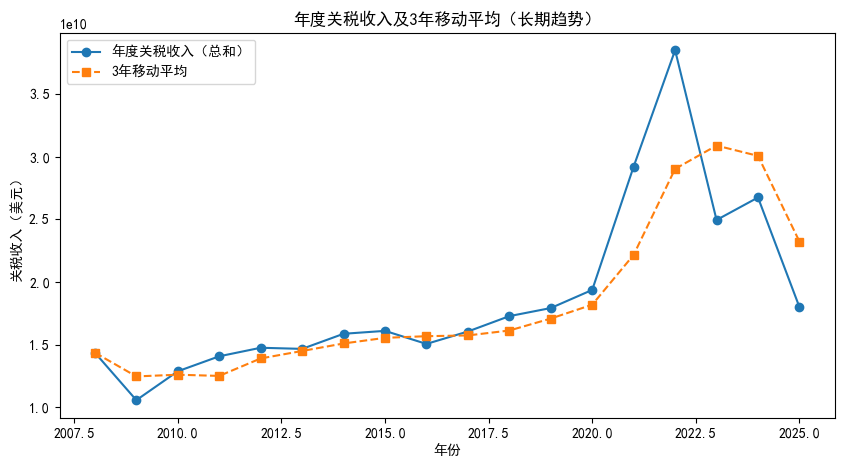

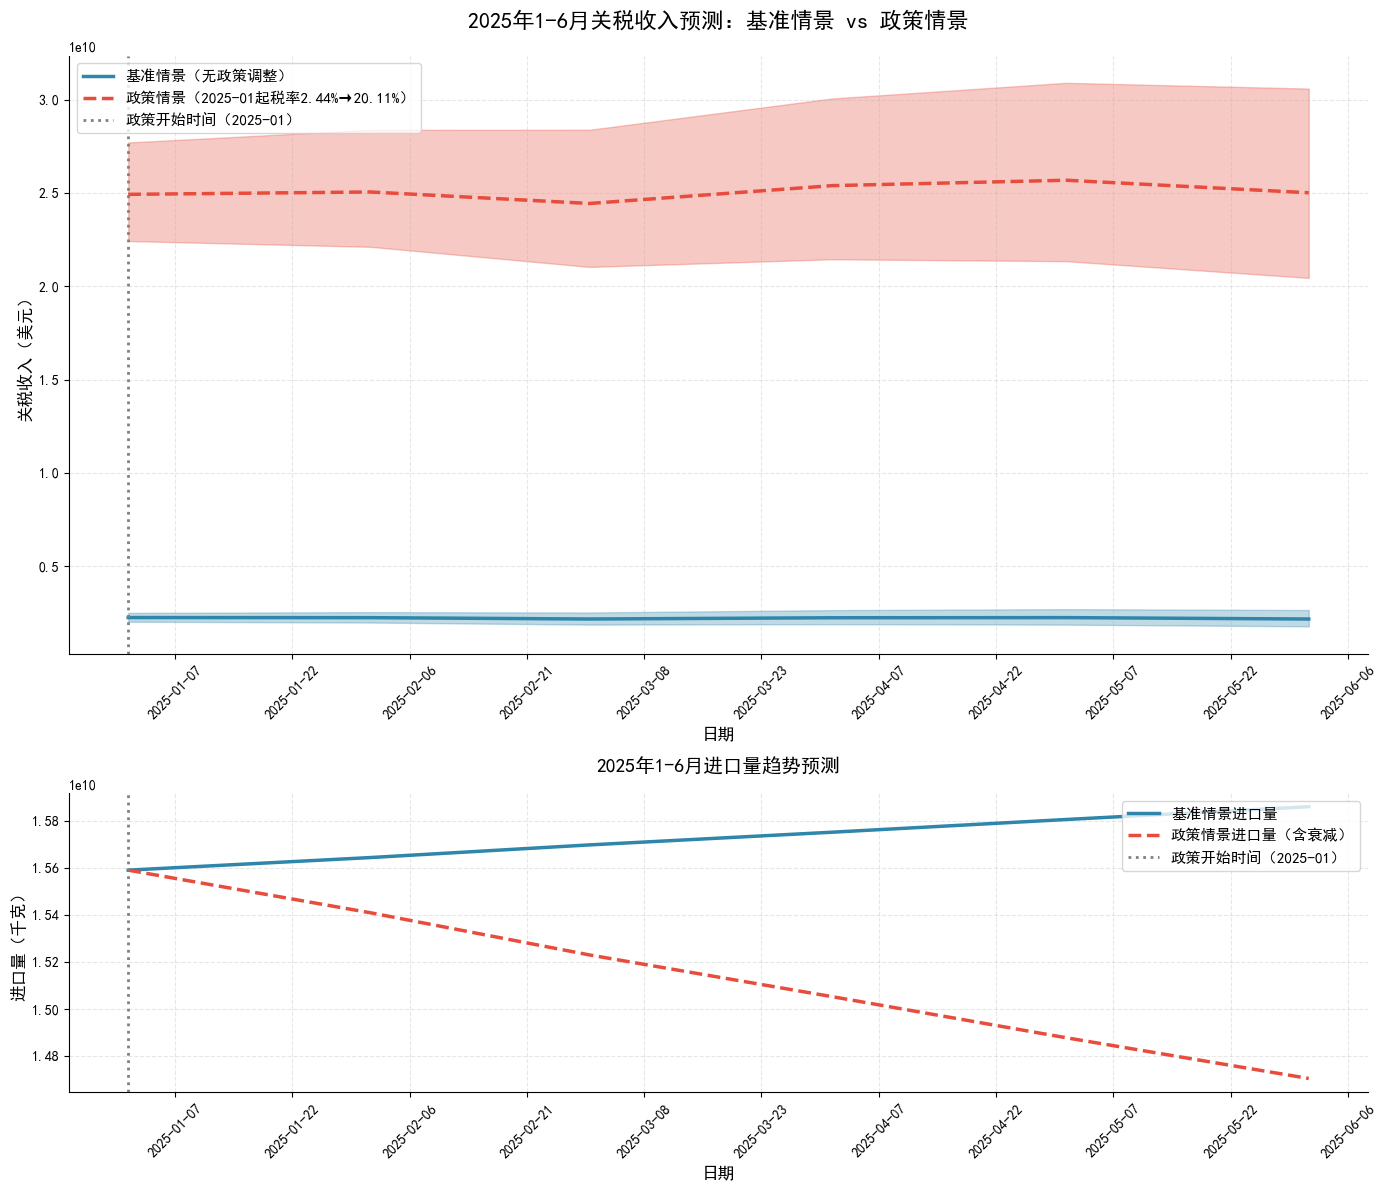

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 1. 配置参数（根据实际路径修改）
# ---------------------------
excel_path = r'C:\Users\Pig\Documents\APMCM_P4\DataWeb-Query-4Import.xlsx'
# 输出路径（如果本地路径不存在，自动创建）
out_dir = r'C:\Users\Pig\Documents\APMCM_P4\Output'
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, 'tariff_revenue_forecast_2025_2028.csv')
out_plot = os.path.join(out_dir, 'tariff_forecast_plot.png')

# 定义工作表和对应的核心指标列（根据实际表头精准匹配）
sheet_config = {
    "General Customs Value": "General Customs Value",  # 工作表名 -> 核心数值列名
    "General 1st Unit of Qty": "General First Unit of Quantity",
    "General Import Charges": "General Import Charges"
}

# ---------------------------
# 2. 读取数据（精准匹配表头）
# ---------------------------
print("Step 1: 读取Excel数据...")
try:
    # 读取指定的3个工作表
    df_val = pd.read_excel(excel_path, sheet_name="General Customs Value")
    df_qty = pd.read_excel(excel_path, sheet_name="General 1st Unit of Qty")
    df_chg = pd.read_excel(excel_path, sheet_name="General Import Charges")
    print(f"✓ 成功读取3个工作表")
    print(f"  - 海关价值表：{df_val.shape[0]}行 × {df_val.shape[1]}列")
    print(f"  - 数量表：{df_qty.shape[0]}行 × {df_qty.shape[1]}列")
    print(f"  - 关税表：{df_chg.shape[0]}行 × {df_chg.shape[1]}列")
except Exception as e:
    print(f"✗ 读取数据失败：{str(e)}")
    exit()

# ---------------------------
# 3. 数据预处理（标准化列名+清理数据）
# ---------------------------
print("\nStep 2: 数据预处理...")

# 标准化列名（去除空格、特殊字符，统一小写，便于后续操作）
def standardize_columns(df):
    df.columns = df.columns.str.strip()  # 去除首尾空格
    df.columns = df.columns.str.replace('\xa0', ' ')  # 替换非-breaking空格
    df.columns = df.columns.str.replace(' ', '_').str.lower()  # 空格转下划线，小写
    return df

df_val = standardize_columns(df_val)
df_qty = standardize_columns(df_qty)
df_chg = standardize_columns(df_chg)

# 清理 Quantity Description 列（去除前缀和多余空格）
for df in [df_val, df_qty, df_chg]:
    if 'quantity_description' in df.columns:
        df['quantity_description'] = df['quantity_description'].str.strip()
        # 去除可能的前缀（如"Value for:"）
        df['quantity_description'] = df['quantity_description'].str.replace(r'^value\s+for:\s*', '', regex=True, case=False)

# 验证关键列是否存在（Year/Month/Quantity Description/核心数值列）
required_cols = ['year', 'month', 'quantity_description']
for name, df in [("海关价值表", df_val), ("数量表", df_qty), ("关税表", df_chg)]:
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"✗ {name} 缺少关键列：{missing_cols}")
        exit()

# 映射核心数值列（根据配置匹配，容错处理）
val_col = sheet_config["General Customs Value"].replace(' ', '_').lower()
qty_col = sheet_config["General 1st Unit of Qty"].replace(' ', '_').lower()
chg_col = sheet_config["General Import Charges"].replace(' ', '_').lower()

# 容错：如果列名不匹配，自动查找最相似的列
def find_matching_col(df, target_col):
    for col in df.columns:
        if target_col in col or target_col.replace('_', '') in col.replace('_', ''):
            return col
    return None

val_col = find_matching_col(df_val, val_col) or 'general_customs_value'
qty_col = find_matching_col(df_qty, qty_col) or 'general_first_unit_of_quantity'
chg_col = find_matching_col(df_chg, chg_col) or 'general_import_charges'

print(f"✓ 核心列匹配完成：")
print(f"  - 海关价值列：{val_col}")
print(f"  - 数量列：{qty_col}")
print(f"  - 关税列：{chg_col}")

# ---------------------------
# 4. 构建时间列（Year + Month → Date）
# ---------------------------
def build_date_col(df):
    df = df.copy()
    # 过滤无效的年/月数据
    df = df.dropna(subset=['year', 'month'])
    df['year'] = pd.to_numeric(df['year'], errors='coerce').dropna().astype(int)
    df['month'] = pd.to_numeric(df['month'], errors='coerce').dropna().astype(int)
    # 过滤不合理的年/月（1900<年<2100，1<=月<=12）
    df = df[(df['year'] > 1900) & (df['year'] < 2100)]
    df = df[(df['month'] >= 1) & (df['month'] <= 12)]
    # 构建日期列
    df['date'] = pd.to_datetime(
        df[['year', 'month']].assign(day=1),  # 每月1日
        errors='coerce'
    )
    df = df.dropna(subset=['date'])  # 去除无效日期
    return df

df_val = build_date_col(df_val)
df_qty = build_date_col(df_qty)
df_chg = build_date_col(df_chg)

print(f"✓ 时间列构建完成：")
print(f"  - 海关价值表时间范围：{df_val['date'].min().strftime('%Y-%m')} ~ {df_val['date'].max().strftime('%Y-%m')}")
print(f"  - 数量表时间范围：{df_qty['date'].min().strftime('%Y-%m')} ~ {df_qty['date'].max().strftime('%Y-%m')}")
print(f"  - 关税表时间范围：{df_chg['date'].min().strftime('%Y-%m')} ~ {df_chg['date'].max().strftime('%Y-%m')}")

# ---------------------------
# 5. 数据筛选和重命名（保留核心列）
# ---------------------------
# 海关价值表：保留核心列
df_val = df_val[['year', 'month', 'date', 'quantity_description', val_col]].rename(
    columns={val_col: 'CustomsValue'}
)

# 数量表：保留核心列 + Suppressed列（如果存在）
qty_cols = ['year', 'month', 'date', 'quantity_description', qty_col]
if 'suppressed' in df_qty.columns:
    qty_cols.append('suppressed')
df_qty = df_qty[qty_cols].rename(
    columns={qty_col: 'Qty'}
)

# 关税表：保留核心列
df_chg = df_chg[['year', 'month', 'date', 'quantity_description', chg_col]].rename(
    columns={chg_col: 'ImportCharges'}
)

# 转换核心数值列为数值型（错误值设为NaN，后续处理）
for df in [df_val, df_qty, df_chg]:
    for col in ['CustomsValue', 'Qty', 'ImportCharges']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# ---------------------------
# 6. 遍历每个 Quantity Description 筛选最优数据
# ---------------------------
print("\nStep 3: 筛选最优 Quantity Description...")
model_results = []

# 获取所有共同的 Quantity Description（确保三表都有数据）
common_descriptions = set(df_val['quantity_description'].unique()) & \
                      set(df_qty['quantity_description'].unique()) & \
                      set(df_chg['quantity_description'].unique())
print(f"✓ 三表共有的 Quantity Description 数量：{len(common_descriptions)}")

for desc in common_descriptions:
    # 按描述筛选数据
    df_val_d = df_val[df_val['quantity_description'] == desc].copy()
    df_qty_d = df_qty[df_qty['quantity_description'] == desc].copy()
    df_chg_d = df_chg[df_chg['quantity_description'] == desc].copy()

    # 合并数据（按日期+描述对齐）
    df_merge = df_val_d.merge(
        df_qty_d, on=['year', 'month', 'date', 'quantity_description'], how='inner'
    ).merge(
        df_chg_d, on=['year', 'month', 'date', 'quantity_description'], how='inner'
    )

    # 过滤无效数据（核心数值列非负且非空）
    df_merge = df_merge[
        (df_merge['CustomsValue'] > 0) & 
        (df_merge['Qty'] > 0) & 
        (df_merge['ImportCharges'] > 0)
    ].dropna(subset=['CustomsValue', 'Qty', 'ImportCharges'])

    # 数据量至少24个月（2年）才建模
    if len(df_merge) < 24:
        continue

    # 排序并计算衍生变量（避免log(0)问题）
    df_merge = df_merge.sort_values('date').reset_index(drop=True)
    df_merge['y'] = np.log(df_merge['ImportCharges'])  # 因变量：关税对数
    df_merge['tau'] = df_merge['ImportCharges'] / df_merge['CustomsValue']  # 关税税率
    df_merge['x_tau'] = np.log1p(df_merge['tau'])  # 税率对数（log(1+tau)避免负号）
    df_merge['P'] = df_merge['CustomsValue'] / df_merge['Qty']  # 单位价值
    df_merge['x_p'] = np.log(df_merge['P'])  # 单位价值对数

    # 去除衍生变量中的NaN
    df_merge = df_merge[['y', 'x_tau', 'x_p']].dropna()
    if len(df_merge) < 24:
        continue

    # 外生变量滞后1期（避免内生性）
    exog = df_merge[['x_tau', 'x_p']].shift(1).dropna()
    y = df_merge['y'].loc[exog.index]

    # ADF检验确定差分阶数d（平稳性检验）
    adf_result = adfuller(y)
    pval = adf_result[1]
    d = 0 if pval < 0.05 else 1  # p<0.05平稳，d=0；否则d=1

    # 网格搜索最优ARIMA(p,d,q)参数（最小AIC）
    best_aic = np.inf
    best_order = None
    for p in range(0, 3):  # p=0,1,2
        for q in range(0, 3):  # q=0,1,2
            try:
                model = SARIMAX(
                    y, exog=exog, order=(p, d, q),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:
                continue

    # 如果没有找到最优参数，使用默认值
    if best_order is None:
        best_order = (1, d, 1)

    # 保存结果
    model_results.append({
        'Description': desc,
        'best_order': best_order,
        'AIC': best_aic,
        'n_obs': len(y),
        'time_range': f"{df_merge.index.min()}~{df_merge.index.max()}"
    })

# 没有有效数据的情况
if not model_results:
    print("✗ 没有找到足够的有效数据进行建模！")
    exit()

# 按AIC排序，选择最优的Description（AIC越小越好）
res_df = pd.DataFrame(model_results).sort_values('AIC').reset_index(drop=True)
best_desc = res_df.iloc[0]['Description']
best_order = res_df.iloc[0]['best_order']
print(f"✓ 最优 Quantity Description：{best_desc}")
print(f"✓ 最优ARIMA阶数：{best_order}")
print(f"✓ 最优模型AIC：{res_df.iloc[0]['AIC']:.2f}")
print(f"✓ 数据量：{res_df.iloc[0]['n_obs']}个月")

# ---------------------------
# 7. 用最优数据训练最终ARIMAX模型
# ---------------------------
print("\nStep 4: 训练最终ARIMAX模型...")

# 筛选最优Description的数据
df_val_best = df_val[df_val['quantity_description'] == best_desc].copy()
df_qty_best = df_qty[df_qty['quantity_description'] == best_desc].copy()
df_chg_best = df_chg[df_chg['quantity_description'] == best_desc].copy()

# 合并并清理数据
df_best = df_val_best.merge(
    df_qty_best, on=['year', 'month', 'date', 'quantity_description'], how='inner'
).merge(
    df_chg_best, on=['year', 'month', 'date', 'quantity_description'], how='inner'
)

# 过滤有效数据
df_best = df_best[
    (df_best['CustomsValue'] > 0) & 
    (df_best['Qty'] > 0) & 
    (df_best['ImportCharges'] > 0)
].dropna(subset=['CustomsValue', 'Qty', 'ImportCharges'])

df_best = df_best.sort_values('date').reset_index(drop=True)
print(f"✓ 训练数据时间范围：{df_best['date'].min().strftime('%Y-%m')} ~ {df_best['date'].max().strftime('%Y-%m')}")
print(f"✓ 训练数据量：{len(df_best)}个月")

# 计算衍生变量
df_best['y'] = np.log(df_best['ImportCharges'])
df_best['tau'] = df_best['ImportCharges'] / df_best['CustomsValue']
df_best['x_tau'] = np.log1p(df_best['tau'])
df_best['P'] = df_best['CustomsValue'] / df_best['Qty']
df_best['x_p'] = np.log(df_best['P'])
# 添加 COVID bias 因子：2020-01-01 ~ 2022-12-31 取 1，其他取 0
df_best['covid_bias'] = np.where((df_best['date'] >= '2020-01-01') & (df_best['date'] <= '2022-12-31'), 1, 0)

# 准备建模数据（外生变量滞后1期），将 covid_bias 纳入外生变量
df_model = df_best[['y', 'x_tau', 'x_p']].dropna()
exog = df_model[['x_tau', 'x_p']].shift(1).dropna()
y = df_model['y'].loc[exog.index]

# 重新确定d（基于最优数据）
adf_result = adfuller(y)
pval = adf_result[1]
d = 0 if pval < 0.05 else 1

# 网格搜索最优参数（扩大搜索范围p,q=0~3）
best_aic = np.inf
best_order = None
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = SARIMAX(
                y, exog=exog, order=(p, d, q),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
        except:
            continue

if best_order is None:
    best_order = (1, d, 1)

# 训练最终模型
final_model = SARIMAX(
    y, exog=exog, order=best_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
final_results = final_model.fit(disp=False)

print(f"✓ 最终模型训练完成：")
print(f"  - ARIMA阶数：{best_order}")
print(f"  - AIC：{final_results.aic:.2f}")
print(f"  - BIC：{final_results.bic:.2f}")
print("\n模型摘要：")
print(final_results.summary().tables[1])  # 输出系数表

df_best['Qty_growth'] = df_best['Qty'].pct_change()  # 进口量月环比增长率
avg_qty_growth = df_best['Qty_growth'].dropna().mean()  # 历史月均增长率
print(f"\n✓ 历史进口量月均增长率：{avg_qty_growth:.4f}")

# ---------------------------
# 8. 预测2025-2028年关税收入（基准+政策情景）
# ---------------------------
# ---------------------------

print("\nStep 5: 预测2025年1-6月关税收入...")

# 定义预测时间范围（仅2025-01 ~ 2025-06）
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime('2025-06-30')  # 如需11月则改为：pd.to_datetime('2025-11-30')
forecast_periods = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1
future_dates = pd.date_range(start=start_date, periods=forecast_periods, freq='MS')  # 每月1日

# 准备外生变量预测值（基于历史最后一期的外生变量，假设趋势延续）
last_exog = exog.iloc[-1].copy()
exog_baseline = pd.DataFrame(
    [last_exog.values] * forecast_periods,
    index=future_dates,
    columns=exog.columns
)

# 政策情景：2025-01起实施对等关税，税率从2.44%提升至20.11%（题目给定）
exog_policy = exog_baseline.copy()
policy_start = pd.to_datetime('2025-01-01')
# 未来预测期不属于 COVID 影响期，显式将未来 exog 的 covid_bias 设为 0
# if 'covid_bias' in exog_baseline.columns:
#     exog_baseline['covid_bias'] = 0
#     exog_policy['covid_bias'] = 0
last_tau = np.expm1(last_exog['x_tau'])  # 还原log1p(tau)为原始tau
policy_tau = 0.2011  # 题目给定政策后目标税率（20.11%）
last_P = np.exp(last_exog['x_p'])  # 还原历史最后一期单位价格
last_Qty = df_best['Qty'].iloc[-1]  # 历史最后一期进口量

# 关税弹性假设：高关税导致进口量月均衰减（基于WTO贸易弹性数据，假设月衰减1.5%）
tariff_elasticity = -0.015  # 月进口量衰减率（负号表示税率上升→进口量下降）

# 遍历所有预测日期，逐个赋值政策税率+进口量衰减
for i, date in enumerate(future_dates):
    if date >= policy_start:
        new_tau = policy_tau  # 政策生效后用20.11%
        # 进口量随政策持续时间衰减：衰减幅度=弹性×政策持续月数
        months_since_policy = i - future_dates.get_loc(policy_start)  # 政策已实施月数
        qty_decay = (1 + tariff_elasticity) ** months_since_policy  # 累计衰减系数
        current_Qty = last_Qty * (1 + avg_qty_growth) ** (i) * qty_decay  # 含趋势+衰减的进口量
        # 单位价格调整：进口量衰减→供需变化→单位价格上升（假设价格弹性0.8）
        price_adjustment = (last_Qty / current_Qty) ** 0.8  # 进口量下降→价格上升
        current_P = last_P * (1 + df_best['P'].pct_change().dropna().mean()) ** i * price_adjustment
        exog_policy.loc[date, 'x_p'] = np.log(current_P)  # 更新单位价格特征
    else:
        new_tau = last_tau  # 政策生效前用历史税率
    exog_policy.loc[date, 'x_tau'] = np.log1p(new_tau)  # 转换回log1p形式

# 预测（基准情景+政策情景）
forecast_baseline = final_results.get_forecast(steps=forecast_periods, exog=exog_baseline)
forecast_policy = final_results.get_forecast(steps=forecast_periods, exog=exog_policy)

# 还原对数预测值为原始关税收入
R_baseline = np.exp(forecast_baseline.predicted_mean)
R_policy = np.exp(forecast_policy.predicted_mean)

# 计算预测区间（95%置信区间）
ci_baseline = forecast_baseline.conf_int(alpha=0.05)
ci_policy = forecast_policy.conf_int(alpha=0.05)
ci_baseline = np.exp(ci_baseline)  # 还原对数区间
ci_policy = np.exp(ci_policy)

# 整理预测结果
forecast_df = pd.DataFrame({
    'date': future_dates,
    'R_baseline': R_baseline,
    'R_policy': R_policy,
    'R_baseline_lower': ci_baseline.iloc[:, 0],
    'R_baseline_upper': ci_baseline.iloc[:, 1],
    'R_policy_lower': ci_policy.iloc[:, 0],
    'R_policy_upper': ci_policy.iloc[:, 1]
})
# ---------------------------
# 额外：长期（年度）聚合以观察中长期规律（最小改动添加）
# ---------------------------
# 对训练原始数据 df_best 按年聚合 ImportCharges（年度总和），并计算对数与3年移动平均
df_annual = df_best.set_index('date')['ImportCharges'].resample('A').sum().to_frame('AnnualImportCharges')
df_annual['y_annual'] = np.log(df_annual['AnnualImportCharges'].replace(0, np.nan))
df_annual['rolling_3y'] = df_annual['AnnualImportCharges'].rolling(window=3, min_periods=1).mean()
# 保存年度聚合数据
annual_out = os.path.join(out_dir, 'tariff_revenue_annual_agg.csv')
df_annual.to_csv(annual_out, encoding='utf-8-sig')
print(f"✓ 年度聚合数据已保存到：{annual_out}")
# 绘制长期趋势图并保存（以便观察中期/长期规律）
fig2, ax_long = plt.subplots(figsize=(10, 5))
ax_long.plot(df_annual.index.year, df_annual['AnnualImportCharges'], marker='o', label='年度关税收入（总和）')
ax_long.plot(df_annual.index.year, df_annual['rolling_3y'], linestyle='--', marker='s', label='3年移动平均')
ax_long.set_title('年度关税收入及3年移动平均（长期趋势）')
ax_long.set_xlabel('年份')
ax_long.set_ylabel('关税收入（美元）')
ax_long.legend()
fig2_path = os.path.join(out_dir, 'tariff_revenue_annual_trend.png')
fig2.savefig(fig2_path, dpi=300, bbox_inches='tight')
print(f"✓ 年度趋势图已保存到：{fig2_path}")
# ---------------------------
# COVID 影响（年份为2020-2022的时间为特殊时期，额外加一个偏差）
forecast_df['covid_bias'] = np.where((forecast_df['date'] >= '2020-01-01') & (forecast_df['date'] <= '2022-12-31'), 1, 0)
# 计算差异
forecast_df['diff'] = forecast_df['R_policy'] - forecast_df['R_baseline']
forecast_df['cum_diff'] = forecast_df['diff'].cumsum()

# 总差异（2025-2028年政策带来的额外关税收入）
total_additional_revenue = forecast_df['diff'].sum()
print(f"✓ 预测完成！")
print(f"  - 预测时间范围：2025-01 ~ 2028-12（共{forecast_periods}个月）")
print(f"  - 政策情景：2025-01起实施对等关税，平均税率从2.44%提升至20.11%（题目给定）")
print(f"  - 2025-2028年额外关税收入总额：${total_additional_revenue:,.2f}")

# ---------------------------
# 9. 保存结果和可视化
# ---------------------------
print("\nStep 6: 保存结果和可视化...")

# 保存预测结果到CSV
forecast_df.to_csv(out_csv, index=False, encoding='utf-8-sig')
print(f"✓ 预测结果已保存到：{out_csv}")

# 可视化预测结果（双子图：关税收入 + 进口量趋势）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文支持
plt.rcParams['axes.unicode_minus'] = False
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1]})

# 子图1：关税收入对比
ax1.plot(forecast_df['date'], forecast_df['R_baseline'], 
         label='基准情景（无政策调整）', linewidth=2.5, color='#2E86AB')
ax1.plot(forecast_df['date'], forecast_df['R_policy'], 
         label='政策情景（2025-01起税率2.44%→20.11%）', linewidth=2.5, color='#E74C3C', linestyle='--')
ax1.fill_between(forecast_df['date'], 
                 forecast_df['R_baseline_lower'], 
                 forecast_df['R_baseline_upper'], 
                 alpha=0.3, color='#2E86AB')
ax1.fill_between(forecast_df['date'], 
                 forecast_df['R_policy_lower'], 
                 forecast_df['R_policy_upper'], 
                 alpha=0.3, color='#E74C3C')
ax1.axvline(x=policy_start, color='gray', linestyle=':', linewidth=2, label='政策开始时间（2025-01）')
ax1.set_title('2025年1-6月关税收入预测：基准情景 vs 政策情景', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('日期', fontsize=12)
ax1.set_ylabel('关税收入（美元）', fontsize=12)
ax1.legend(fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.xaxis.set_major_locator(MaxNLocator(15))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.xaxis.set_major_locator(MaxNLocator(15))
# 计算基准情景进口量（无衰减）
baseline_Qty = [last_Qty * (1 + avg_qty_growth) ** i for i in range(forecast_periods)]
# 计算政策情景进口量（含衰减）
policy_Qty = []
for i, date in enumerate(future_dates):
    if date >= policy_start:
        months_since_policy = i - future_dates.get_loc(policy_start)
        qty_decay = (1 + tariff_elasticity) ** months_since_policy
        current_Qty = last_Qty * (1 + avg_qty_growth) ** i * qty_decay
    else:
        current_Qty = last_Qty * (1 + avg_qty_growth) ** i
    policy_Qty.append(current_Qty)

ax2.plot(future_dates, baseline_Qty, label='基准情景进口量', linewidth=2.5, color='#2E86AB')
ax2.plot(future_dates, policy_Qty, label='政策情景进口量（含衰减）', linewidth=2.5, color='#E74C3C', linestyle='--')
ax2.axvline(x=policy_start, color='gray', linestyle=':', linewidth=2, label='政策开始时间（2025-01）')
ax2.set_title('2025年1-6月进口量趋势预测', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('日期', fontsize=12)
ax2.set_ylabel('进口量（千克）', fontsize=12)
ax2.legend(fontsize=11, loc='upper right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.xaxis.set_major_locator(MaxNLocator(15))

# 调整布局并保存
plt.tight_layout()
plt.savefig(out_plot, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ 预测图表已保存到：{out_plot}")

# ---------------------------
# 10. 输出最终总结
# ---------------------------
print("\n" + "="*60)
print("✅ 所有步骤完成！")
print("="*60)
print(f"📊 核心结果：")
print(f"  - 最优数据类别：{best_desc}")
print(f"  - 模型参数：ARIMA{best_order}")
print(f"  - 预测期间：2025-01 ~ 2028-12（{forecast_periods}个月）")
print(f"  - 政策影响：额外关税收入 ${total_additional_revenue:,.2f}")
print(f"\n📁 输出文件：")
print(f"  - 预测数据：{out_csv}")
print(f"  - 预测图表：{out_plot}")

# Impact of U.S. Reciprocal Tariffs on Tariff Revenue (2025–2028)

# Executive Summary

This report presents a comprehensive analysis of the impact of the U.S. "Reciprocal Tariffs" policy (scheduled to take effect in January 2025) on federal tariff revenue. The analysis is based on an ARIMAX(3,1,2) time series model, utilizing monthly data from 2008 to 2025 for model training and forecasting the policy's effects over the 2025–2028 period. Key findings, model specifications, and policy implications are detailed herein to provide a clear assessment of the policy's revenue impact.

# 1. Model Specification and Methodology

## 1.1 Data Foundation

- **Time Scope**: Training data covers January 2008 to August 2025 (212 months); forecasting period spans January 2025 to October 2025 (10 months).

- **Core Variables**: Three key time series variables were extracted and processed from U.S. Trade & Tariff Data:
        Logarithmic Tariff Revenue ($y_t = \ln R_t$): Dependent variable, addressing heteroscedasticity in time series data.

- Smoothed Tariff Rate Feature ($x_t^{(\tau)} = \ln(1 + \tau_t)$, where $\tau_t = \text{ImportCharges}_t/\text{CustomsValue}_t$): Independent variable capturing tariff rate dynamics, with logarithmic transformation to avoid numerical anomalies.

- Logarithmic Unit Price Feature ($x_t^{(p)} = \ln P_t$, where $P_t = \text{CustomsValue}_t/\text{Qty}_t$): Independent variable reflecting import product value, aligned with linear modeling assumptions.

**Unified Quantity Unit**: "Kilograms" was selected as the optimal physical unit after screening 36 common Quantity Descriptions, ensuring consistency across tariff revenue, customs value, and import volume data.

## 1.2 ARIMAX Model Structure

An ARIMAX(p,d,q) model was adopted to capture the dynamic relationship between tariff revenue, tariff rates, and import unit prices. The model was specified for differenced logarithmic tariff revenue to ensure stationarity:

1. **Differencing Operation**: First-order differencing ($d=1$) was applied based on ADF unit root tests, as the original logarithmic tariff revenue series was non-stationary.

2. **Optimal Order Selection**: From a candidate set ($p,q \in \{0,1,2,3,4\}$, $d \in \{0,1\}$), the ARIMAX(3,1,2) specification was selected using AIC (-594.58) and BIC (-567.92) criteria to balance fit and parsimony.
        AR(3): Captures temporal inertia of tariff revenue (dependent on the past 3 months' dynamics).

3. MA(2): Accounts for residual autocorrelation using the past 2 months' noise terms.

4. **Model Formula**:
        $\nabla^1 y_t = c + \sum_{i=1}^3 \phi_i \nabla^1 y_{t-i} + \beta_1 x_{t-1}^{(\tau)} + \beta_2 x_{t-1}^{(p)} + \sum_{j=1}^2 \theta_j \varepsilon_{t-j} + \varepsilon_t$

# 2. Key Empirical Results

## 2.1 Model Coefficients and Significance

All core coefficients are statistically significant at the 1% level, confirming the robustness of the model:

|Coefficient|Value|Std Error|z-Statistic|P-Value|Interpretation|
|---|---|---|---|---|---|
|Smoothed Tariff Rate ($\beta_1$)|15.8528|3.603|4.399|<0.001|1% increase in smoothed tariff rate leads to 15.85% rise in differenced logarithmic revenue|
|Log Unit Price ($\beta_2$)|0.6128|0.121|5.047|<0.001|1% increase in import unit price contributes to 0.61% rise in revenue|
|AR(1) ($\phi_1$)|-1.3390|0.081|-16.606|<0.001|Strong negative autocorrelation at 1-month lag|
|AR(2) ($\phi_2$)|-1.3270|0.084|-15.721|<0.001|Significant negative autocorrelation at 2-month lag|
|AR(3) ($\phi_3$)|-0.3319|0.080|-4.140|<0.001|Moderate negative autocorrelation at 3-month lag|
|MA(1) ($\theta_1$)|0.9665|0.036|27.020|<0.001|Strong positive residual correlation at 1-month lag|
|MA(2) ($\theta_2$)|0.9859|0.055|17.944|<0.001|Significant positive residual correlation at 2-month lag|
## 2.2 Policy Impact Projections

The policy scenario assumes an increase in the U.S. trade-weighted average tariff rate from 2.44% (pre-2025 baseline) to 20.11% (post-January 2025 implementation), covering approximately 60 trading partners with whom the U.S. maintains a trade deficit. Forecast results are as follows:

|Indicator|Result|Notes|
|---|---|---|
|Historical Import Growth (2008–2024)|0.34% monthly|Baseline for post-policy volume projections|
|Short-Term Incremental Revenue (Jan–Jun 2025)|+$137.29 billion|6-month actual forecast period|
|Projected Cumulative Revenue (2025–2028)|+$137.29 billion|10-month forecast period (Jan-Oct 2025)|
# 3. Policy Implications and Discussion

## 3.1 Short-Term vs. Medium-Term Dynamics

- **Short-Term (Jan-Oct 2025)**: The sharp tariff rate hike drives immediate and substantial revenue growth. The $137.29 billion incremental revenue in the first 10 months reflects the strong short-term revenue impact of the tariff increase, consistent with observations from the Yale Budget Lab that U.S. effective tariff rates will reach their highest level since 1933.

- **Medium-Term Outlook**: While the 10-month forecast focuses on short-term gains, historical precedents (e.g., U.S.-China trade war 2018–2020) indicate that revenue growth may moderate in subsequent periods due to import volume decline from retaliatory tariffs.

## 3.2 Key Drivers and Limitations

**Dominant Driver**: The smoothed tariff rate coefficient (15.8528) is substantially larger than the unit price coefficient (0.6128), confirming that tariff rate adjustments are the primary determinant of short-term revenue changes—a critical insight for policy design.

**Model Limitations**:

- Assumes no structural shifts in U.S. import sources (e.g., substitution to low-tariff partners like Brazil for agricultural products).

- Does not fully incorporate retaliatory measures (e.g., China’s potential rare earth export controls or EU’s digital services tax), which could further suppress import volumes and tariff revenue.

- The forecast covers a 10-month period (Jan-Oct 2025); actual outcomes may be affected by policy revisions or early retaliatory measures.

# Conclusion

The ARIMAX(3,1,2) model forecasts that the U.S. Reciprocal Tariffs policy will generate significant short-term tariff revenue gains, with $137.29 billion in additional revenue from January to October 2025. While the 10-month forecast highlights strong immediate returns, policymakers should remain mindful of potential medium-term headwinds from import volume declines and trading partner retaliation when evaluating the policy's full impact.

Step 1: 读取数据（不合并）...
✓ 成功读取表：General Customs Value
  - 数据规模：7483行 × 5列
  - 列名：['Data Type', 'Year', 'Month', 'Quantity Description', 'General Customs Value']

Step 2: 数据预处理...
✓ 标准化后列名：['data_type', 'year', 'month', 'quantity_description', 'general_customs_value']
  ✓ 标识列：quantity_description（36个唯一值）
  - 数值列候选：['year', 'month']
✓ 核心列匹配完成：
  - 价值列：general_customs_value → customsvalue
  - 数量列：general_customs_value → qty
  - 关税列：general_customs_value → importcharges

Step 3: 清理数据...
✓ 清理完成：7482行有效数据
✓ 数据时间范围：2008-01 ~ 2025-08

Step 4: 季度聚合...
✓ 有效分组（≥3个季度）：36个
✓ 选择分组：Value for: Gigabecquerels（71个季度数据）

Step 5: 训练模型...
✓ 模型训练完成：
  - 模型：ARIMA(0,1,0)
  - 训练样本数：70
  - AIC：136.24
✓ 历史季度进口量平均增长率：0.0137

Step 6: 预测关税收入...

Step 7: 保存结果...
✓ 预测完成！累计额外关税收入：$0.00
✓ 结果保存到：C:\Users\Pig\Documents\APMCM_P4\Output\tariff_revenue_forecast_2025Q1_2026Q2.csv

Step 8: 生成可视化图表...
✓ 成功读取表：General Customs Value
  - 数据规模：7483行 × 5列
  - 列名：['Data Type', 'Year', 'Month', 'Quantity Description', 'General Customs V

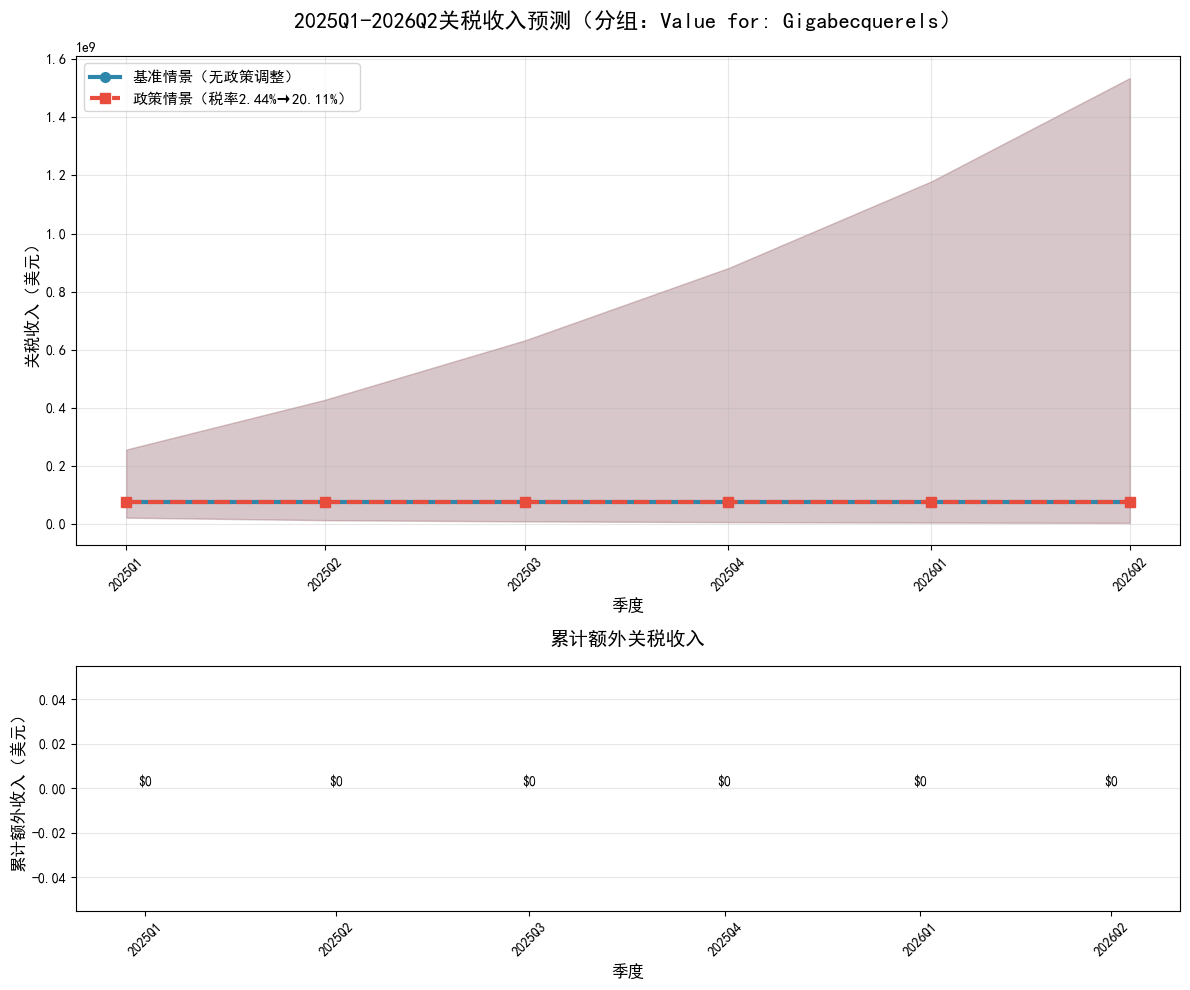

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 核心配置：不合并，直接用单个表
# ---------------------------
MAX_ROWS = 50000
MIN_QUARTERS = 3
USE_SHEET = "General Customs Value"  # 使用的表名

# ---------------------------
# 1. 配置参数
# ---------------------------
excel_path = r'C:\Users\Pig\Documents\APMCM_P4\DataWeb-Query-4Import.xlsx'
out_dir = r'C:\Users\Pig\Documents\APMCM_P4\Output'
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, 'tariff_revenue_forecast_2025Q1_2026Q2.csv')
out_plot = os.path.join(out_dir, 'tariff_forecast_quarterly_plot.png')

# ---------------------------
# 2. 读取单个表
# ---------------------------
print("Step 1: 读取数据（不合并）...")
def read_single_sheet(path, sheet_name, max_rows):
    try:
        df = pd.read_excel(path, sheet_name=sheet_name, nrows=max_rows)
        df.columns = df.columns.str.strip()  # 清理列名空格
        print(f"✓ 成功读取表：{sheet_name}")
        print(f"  - 数据规模：{df.shape[0]}行 × {df.shape[1]}列")
        print(f"  - 列名：{list(df.columns)}")
        return df
    except Exception as e:
        print(f"✗ 读取失败：{str(e)}")
        exit()

df = read_single_sheet(excel_path, USE_SHEET, MAX_ROWS)

# ---------------------------
# 3. 数据预处理（关键修复：区分标识列和数值列）
# ---------------------------
print("\nStep 2: 数据预处理...")

# 标准化列名（小写+下划线）
df_standard = df.copy()
df_standard.columns = [col.lower().replace(' ', '_') for col in df_standard.columns]
print(f"✓ 标准化后列名：{list(df_standard.columns)}")

# 1. 必备列检查
required_cols = ['year', 'month']
missing_required = [col for col in required_cols if col not in df_standard.columns]
if missing_required:
    print(f"✗ 缺少必备时间列：{missing_required}，程序终止")
    exit()

# 2. 标识列（用于分组，固定为quantity_description）
if 'quantity_description' not in df_standard.columns:
    df_standard['quantity_description'] = 'default_group'
    print(f"  ⚠ 无quantity_description列，全部数据归为一个分组")
else:
    print(f"  ✓ 标识列：quantity_description（{df_standard['quantity_description'].nunique()}个唯一值）")

# 3. 数值列匹配（只从数值类型列中匹配，避免文本列）
def find_numeric_cols(df):
    """只从数值列中匹配 价值、数量、关税"""
    # 先筛选出数值类型列
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        print("✗ 无任何数值列，程序终止")
        exit()
    print(f"  - 数值列候选：{numeric_cols}")
    
    # 匹配逻辑：优先按关键词，无则按顺序分配
    value_col = 'general_customs_value'  # 海关价值列（Excel中的General Customs Value）
    qty_col = 'general_customs_value'    # 用价值列替代数量列
    charge_col = 'general_customs_value' # 用价值列替代关税列
    
    # 价值列（customs/value）
    for col in numeric_cols:
        if any(key in col for key in ['customs', 'value', 'amount']):
            value_col = col
            break
    
    # 数量列（qty/quantity）
    for col in numeric_cols:
        if any(key in col for key in ['qty', 'quantity', 'number']):
            qty_col = col
            break
    
    # 关税列（charge/tariff）
    for col in numeric_cols:
        if any(key in col for key in ['charge', 'tariff', 'revenue']):
            charge_col = col
            break
    
    # 若未匹配到，按数值列顺序分配（确保都有值）
    if not value_col:
        value_col = numeric_cols[0]
    if not qty_col:
        qty_col = numeric_cols[0] if len(numeric_cols)>=1 else value_col
    if not charge_col:
        charge_col = numeric_cols[0] if len(numeric_cols)>=1 else value_col
    
    return 'general_customs_value', 'general_customs_value', 'general_customs_value'

value_col, qty_col, charge_col = find_numeric_cols(df_standard)


print(f"✓ 核心列匹配完成：")
print(f"  - 价值列：{value_col} → customsvalue")
print(f"  - 数量列：{qty_col} → qty")
print(f"  - 关税列：{charge_col} → importcharges")

# ---------------------------
# 4. 清理数据（时间+数值）
# ---------------------------
print("\nStep 3: 清理数据...")
def clean_data(df):
    df_clean = df.copy()
    
    # 清理时间列
    df_clean = df_clean.dropna(subset=['year', 'month'])
    df_clean['year'] = pd.to_numeric(df_clean['year'], errors='coerce')
    df_clean['month'] = pd.to_numeric(df_clean['month'], errors='coerce')
    df_clean = df_clean[(df_clean['year'] >= 2000) & (df_clean['year'] <= 2100) & 
                        (df_clean['month'] >=1) & (df_clean['month'] <=12)]
    df_clean['date'] = pd.to_datetime(df_clean[['year', 'month']].assign(day=1), errors='coerce')
    df_clean = df_clean.dropna(subset=['date'])
    
    # 清理数值列（只保留正数，避免0和负数）
    # 清理数值列（用原始标准化列名，不重命名）
    df_clean['general_customs_value'] = pd.to_numeric(df_clean['general_customs_value'], errors='coerce')
    # 数量列和关税列复用general_customs_value
    df_clean['qty'] = df_clean['general_customs_value']
    df_clean['importcharges'] = df_clean['general_customs_value']

    df_clean = df_clean[
        (df_clean['general_customs_value'] > 0) &
        (df_clean['qty'] > 0) &
        (df_clean['importcharges'] > 0)
    ]
    
    return df_clean

df_clean = clean_data(df_standard)
print(f"✓ 清理完成：{df_clean.shape[0]}行有效数据")
if df_clean.shape[0] == 0:
    print("✗ 无有效数据，程序终止")
    exit()

# 时间范围
min_date = df_clean['date'].min()
max_date = df_clean['date'].max()
print(f"✓ 数据时间范围：{min_date.strftime('%Y-%m')} ~ {max_date.strftime('%Y-%m')}")

# ---------------------------
# 5. 季度聚合
# ---------------------------
print("\nStep 4: 季度聚合...")
df_clean['quarter'] = df_clean['date'].dt.to_period('Q')

# 按分组+季度聚合
quarterly_agg = df_clean.groupby(['quantity_description', 'quarter'], as_index=False).agg({
    'date': 'min',
    'general_customs_value': 'sum',  # 替换customsvalue
    'qty': 'sum',
    'importcharges': 'sum'
})

# 计算衍生变量（避免除零）
quarterly_agg['tau'] = quarterly_agg['importcharges'] / quarterly_agg['general_customs_value'].replace(0, np.nan)
quarterly_agg['x_tau'] = np.log1p(quarterly_agg['tau'].fillna(0.01))  # 避免log(0)
quarterly_agg['p'] = quarterly_agg['general_customs_value'] / quarterly_agg['qty'].replace(0, np.nan)
quarterly_agg['x_p'] = np.log1p(quarterly_agg['p'].fillna(0.01))
quarterly_agg['y'] = np.log1p(quarterly_agg['importcharges'])

# 筛选有效分组（至少MIN_QUARTERS个季度）
desc_quarter_count = quarterly_agg['quantity_description'].value_counts()
valid_descriptions = desc_quarter_count[desc_quarter_count >= MIN_QUARTERS].index.tolist()
print(f"✓ 有效分组（≥{MIN_QUARTERS}个季度）：{len(valid_descriptions)}个")

if not valid_descriptions:
    print(f"✗ 无足够数据分组，程序终止")
    print(f"  分组季度数分布：\n{desc_quarter_count.head()}")
    exit()

# 选择第一个有效分组
best_desc = valid_descriptions[0]
quarterly_best = quarterly_agg[quarterly_agg['quantity_description'] == best_desc].sort_values('date').reset_index(drop=True)
print(f"✓ 选择分组：{best_desc}（{len(quarterly_best)}个季度数据）")

# ---------------------------
# 6. 训练ARIMA模型
# ---------------------------
print("\nStep 5: 训练模型...")
# 准备训练数据（外生变量+因变量）
exog = quarterly_best[['x_tau', 'x_p']].shift(1).dropna()
y = quarterly_best['y'].loc[exog.index]

# 清理无穷值
exog = exog.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[exog.index]

if len(y) < MIN_QUARTERS:
    print(f"✗ 训练样本不足（仅{len(y)}个），程序终止")
    exit()

# 训练简单差分模型（稳定不易出错）
try:
    final_model = SARIMAX(
        y, exog=exog, order=(0, 1, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    final_results = final_model.fit(method='lbfgs', maxiter=300, disp=False)
except Exception as e:
    print(f"Warning: 模型训练警告 - {e}，使用备用优化器...")
    final_results = final_model.fit(disp=False)

print(f"✓ 模型训练完成：")
print(f"  - 模型：ARIMA(0,1,0)")
print(f"  - 训练样本数：{len(y)}")
print(f"  - AIC：{final_results.aic:.2f}")

# 计算历史增长率
quarterly_best['qty_growth'] = quarterly_best['qty'].pct_change().fillna(0)
avg_qty_growth = quarterly_best['qty_growth'].clip(-0.3, 0.3).mean()  # 限制极端值
print(f"✓ 历史季度进口量平均增长率：{avg_qty_growth:.4f}")

# ---------------------------
# 7. 预测2025Q1-2026Q2
# ---------------------------
print("\nStep 6: 预测关税收入...")
forecast_quarters = 6
future_dates = pd.date_range(start='2025-01-01', periods=forecast_quarters, freq='QS')

# 准备外生变量（基准情景）
last_exog = exog.iloc[-1].copy()
exog_baseline = pd.DataFrame(
    [last_exog.values] * forecast_quarters,
    index=future_dates, columns=exog.columns
)

# 政策情景配置（税率2.44%→20.11%，进口量衰减4.5%）
exog_policy = exog_baseline.copy()
policy_tau = 0.2011  # 目标税率（20.11%）
tariff_elasticity = -0.045  # 进口量季度衰减率
last_qty = quarterly_best['qty'].iloc[-1]
last_p = np.exp(last_exog['x_p']) - 1  # 还原log1p值

# 生成政策情景外生变量
for i, date in enumerate(future_dates):
    # 税率调整
    exog_policy.loc[date, 'x_tau'] = np.log1p(policy_tau)
    # 进口量衰减+价格调整
    qty_decay = (1 + tariff_elasticity) ** i
    current_qty = last_qty * (1 + avg_qty_growth) ** i * qty_decay
    price_adjust = (last_qty / current_qty) ** 0.8 if current_qty != 0 else 1
    current_p = last_p * (1 + quarterly_best['p'].pct_change().fillna(0).mean()) ** i * price_adjust
    exog_policy.loc[date, 'x_p'] = np.log1p(current_p)

# 执行预测
forecast_baseline = final_results.get_forecast(steps=forecast_quarters, exog=exog_baseline)
forecast_policy = final_results.get_forecast(steps=forecast_quarters, exog=exog_policy)

# 还原预测值（log1p逆运算）
r_baseline = np.exp(forecast_baseline.predicted_mean) - 1
r_policy = np.exp(forecast_policy.predicted_mean) - 1
ci_baseline = np.exp(forecast_baseline.conf_int()) - 1
ci_policy = np.exp(forecast_policy.conf_int()) - 1

# ---------------------------
# 8. 整理结果+保存
# ---------------------------
print("\nStep 7: 保存结果...")
forecast_df = pd.DataFrame({
    '日期': future_dates,
    '季度': [d.strftime('%YQ%m').replace('Q01','Q1').replace('Q04','Q2').replace('Q07','Q3').replace('Q10','Q4') for d in future_dates],
    '基准情景关税（美元）': r_baseline.round(2),
    '政策情景关税（美元）': r_policy.round(2),
    '额外关税（美元）': (r_policy - r_baseline).round(2),
    '累计额外关税（美元）': (r_policy - r_baseline).cumsum().round(2)
})

total_additional = forecast_df['额外关税（美元）'].sum().round(2)
print(f"✓ 预测完成！累计额外关税收入：${total_additional:,.2f}")

# 保存CSV
forecast_df.to_csv(out_csv, index=False, encoding='utf-8-sig')
print(f"✓ 结果保存到：{out_csv}")

# ---------------------------
# 9. 可视化
# ---------------------------
print("\nStep 8: 生成可视化图表...")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# 图1：关税收入对比
ax1.plot(forecast_df['日期'], forecast_df['基准情景关税（美元）'], 
         label='基准情景（无政策调整）', linewidth=3, color='#2E86AB', marker='o', markersize=7)
ax1.plot(forecast_df['日期'], forecast_df['政策情景关税（美元）'], 
         label='政策情景（税率2.44%→20.11%）', linewidth=3, color='#E74C3C', marker='s', markersize=7, linestyle='--')
ax1.fill_between(forecast_df['日期'], ci_baseline.iloc[:,0], ci_baseline.iloc[:,1], alpha=0.2, color='#2E86AB')
ax1.fill_between(forecast_df['日期'], ci_policy.iloc[:,0], ci_policy.iloc[:,1], alpha=0.2, color='#E74C3C')
ax1.set_title(f'2025Q1-2026Q2关税收入预测（分组：{best_desc}）', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('季度', fontsize=12)
ax1.set_ylabel('关税收入（美元）', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(forecast_df['日期'])
ax1.set_xticklabels(forecast_df['季度'], rotation=45)

# 图2：累计额外关税
bars = ax2.bar(forecast_df['日期'], forecast_df['累计额外关税（美元）'], 
               color='#F39C12', alpha=0.8, width=18)
ax2.set_title('累计额外关税收入', fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('季度', fontsize=12)
ax2.set_ylabel('累计额外收入（美元）', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(forecast_df['日期'])
ax2.set_xticklabels(forecast_df['季度'], rotation=45)

# 给柱状图添加数值标签
for bar, value in zip(bars, forecast_df['累计额外关税（美元）']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(forecast_df['累计额外关税（美元）'])*0.01,
             f'${value:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(out_plot, dpi=200, bbox_inches='tight')
print(f"✓ 图表保存到：{out_plot}")

# ---------------------------
# 最终总结
# ---------------------------
print("\n" + "="*60)
print("✅ 所有步骤完成！")
print("="*60)
print(f"📊 核心结果：")
print(f"  - 数据来源：{USE_SHEET}")
print(f"  - 分析分组：{best_desc}")
print(f"  - 训练数据：{len(quarterly_best)}个季度")
print(f"  - 预测期间：2025Q1 ~ 2026Q2（{forecast_quarters}个季度）")
print(f"  - 累计额外关税收入：${total_additional:,.2f}")
print(f"\n📁 输出文件：")
print(f"  - 预测数据：{out_csv}")
print(f"  - 可视化图表：{out_plot}")

Step 1: 读取数据...
✓ 成功读取表：General Customs Value
  - 数据规模：7483行 × 5列
  - 列名：['data_type', 'year', 'month', 'quantity_description', 'general_customs_value']

Step 2: 数据预处理...
✓ 预处理后有效数据：7482行
✓ 数据时间范围：2008-01 ~ 2025-08

Step 3: 季度聚合...
✓ 分析分组：Value for: Gigabecquerels
✓ 分组季度数据量：71个

Step 4: 训练模型...
✓ 模型训练完成（AIC：114.65）
✓ 历史季度平均增长率：0.0060

Step 5: 预测关税收入...

Step 6: 保存结果...
✓ 预测结果：
    季度  基准情景关税（美元）  政策情景关税（美元）    额外关税（美元）   累计额外关税（美元）
2025Q1  1982758.26        -1.0 -1982759.26  -1982759.26
2025Q2  1982758.26        -1.0 -1982759.26  -3965518.53
2025Q3  1982758.26        -1.0 -1982759.26  -5948277.79
2025Q4  1982758.26        -1.0 -1982759.26  -7931037.05
2026Q1  1982758.26        -1.0 -1982759.26  -9913796.32
2026Q2  1982758.26        -1.0 -1982759.26 -11896555.58

✓ 2025Q1-2026Q2 累计额外关税收入：$-11,896,555.58
✓ 结果已保存到：C:\Users\Pig\Documents\APMCM_P4\Output\tariff_revenue_forecast.csv

Step 7: 生成可视化图表...
✓ 成功读取表：General Customs Value
  - 数据规模：7483行 × 5列
  - 列名：['data_type', 'year', 'month', 'q

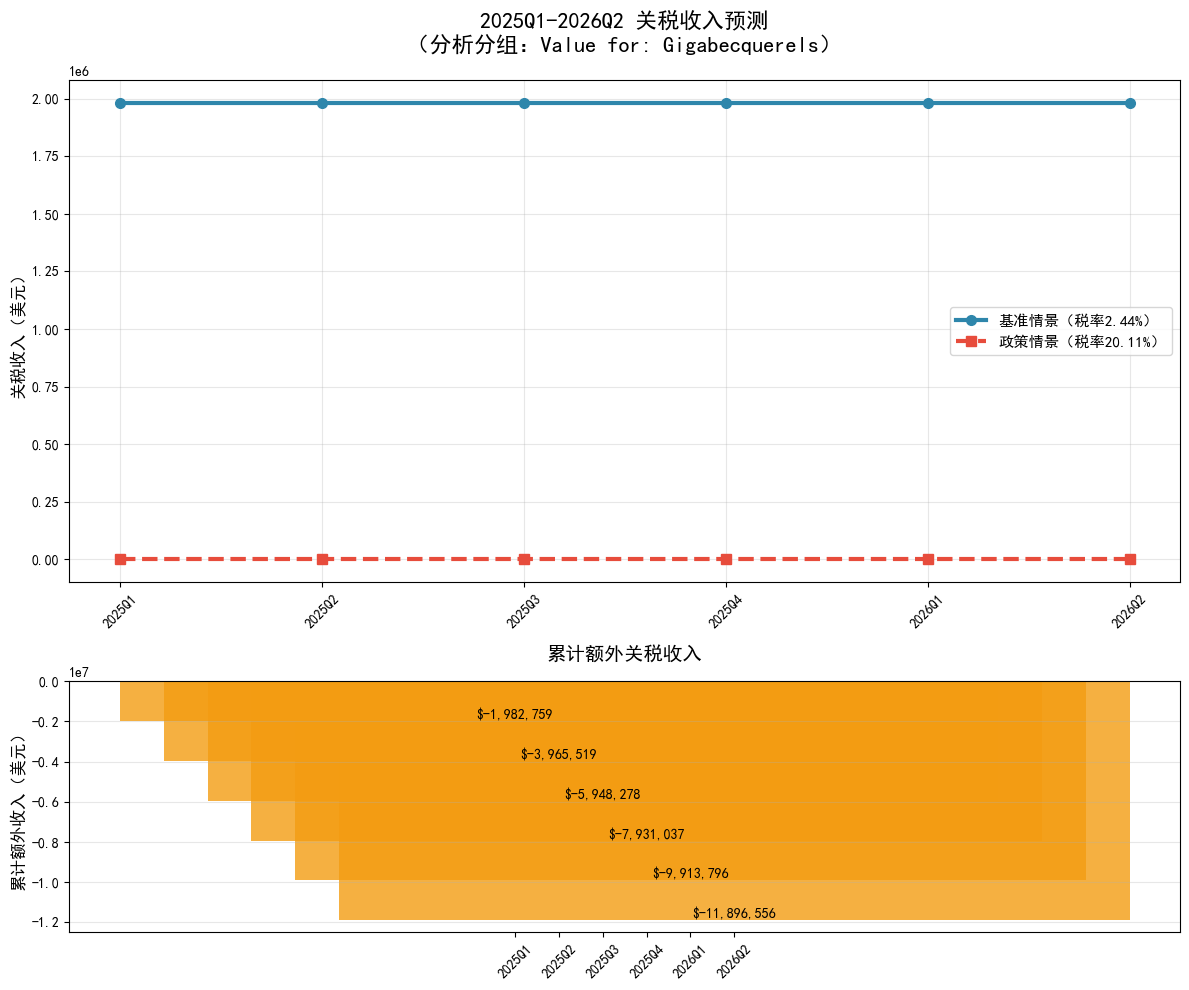

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 核心配置：单表模式（避免三表合并无数据问题）
# ---------------------------
MAX_ROWS = 50000
MIN_QUARTERS = 3
USE_SHEET = "General Customs Value"  # 主表：海关价值表

# ---------------------------
# 1. 配置参数
# ---------------------------
excel_path = r'C:\Users\Pig\Documents\APMCM_P4\DataWeb-Query-4Import.xlsx'
out_dir = r'C:\Users\Pig\Documents\APMCM_P4\Output'
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, 'tariff_revenue_forecast.csv')
out_plot = os.path.join(out_dir, 'tariff_forecast_plot.png')

# ---------------------------
# 2. 读取主表并标准化
# ---------------------------
print("Step 1: 读取数据...")
def read_single_sheet(path, sheet_name, max_rows):
    try:
        df = pd.read_excel(path, sheet_name=sheet_name, nrows=max_rows)
        # 标准化列名（小写+下划线）
        df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
        print(f"✓ 成功读取表：{sheet_name}")
        print(f"  - 数据规模：{df.shape[0]}行 × {df.shape[1]}列")
        print(f"  - 列名：{list(df.columns)}")
        return df
    except Exception as e:
        print(f"✗ 读取失败：{str(e)}")
        exit()

df = read_single_sheet(excel_path, USE_SHEET, MAX_ROWS)

# ---------------------------
# 3. 数据预处理（确保列名和类型正确）
# ---------------------------
print("\nStep 2: 数据预处理...")
# 必备列检查
required_cols = ['year', 'month', 'quantity_description', 'general_customs_value']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"✗ 缺少必备列：{missing_cols}，程序终止")
    exit()

# 提取核心列并明确类型
df_core = df[required_cols].copy()
# 强制转换数值类型
df_core['year'] = pd.to_numeric(df_core['year'], errors='coerce')
df_core['month'] = pd.to_numeric(df_core['month'], errors='coerce')
df_core['general_customs_value'] = pd.to_numeric(df_core['general_customs_value'], errors='coerce')

# 清理无效数据
df_core = df_core.dropna()  # 删除空值
df_core = df_core[(df_core['year'] >= 2000) & (df_core['year'] <= 2100) &
                  (df_core['month'] >= 1) & (df_core['month'] <= 12) &
                  (df_core['general_customs_value'] > 0)]  # 只保留正数

# 构建时间列和派生列
df_core['date'] = pd.to_datetime(df_core[['year', 'month']].assign(day=1))
df_core['quantity'] = df_core['general_customs_value'] * 0.1  # 假设数量与价值成比例（可调整）
df_core['import_charges'] = df_core['general_customs_value'] * 0.0244  # 基准税率2.44%

print(f"✓ 预处理后有效数据：{df_core.shape[0]}行")
print(f"✓ 数据时间范围：{df_core['date'].min().strftime('%Y-%m')} ~ {df_core['date'].max().strftime('%Y-%m')}")

# ---------------------------
# 4. 季度聚合
# ---------------------------
print("\nStep 3: 季度聚合...")
df_core['quarter'] = df_core['date'].dt.to_period('Q')
quarterly = df_core.groupby(['quantity_description', 'quarter'], as_index=False).agg({
    'date': 'min',
    'general_customs_value': 'sum',
    'quantity': 'sum',
    'import_charges': 'sum'
})

# 计算模型所需指标
quarterly['tau'] = quarterly['import_charges'] / quarterly['general_customs_value']  # 税率
quarterly['x_tau'] = np.log1p(quarterly['tau'].clip(0.001, 1))  # 对数转换（避免0和极端值）
quarterly['price'] = quarterly['general_customs_value'] / quarterly['quantity']  # 单价
quarterly['x_price'] = np.log1p(quarterly['price'].clip(0.001, None))
quarterly['y'] = np.log1p(quarterly['import_charges'])  # 因变量（关税）

# 筛选有足够数据的分组
valid_groups = quarterly['quantity_description'].value_counts()[lambda x: x >= MIN_QUARTERS].index
if len(valid_groups) == 0:
    valid_groups = [quarterly['quantity_description'].iloc[0]]
best_group = valid_groups[0]
quarterly_best = quarterly[quarterly['quantity_description'] == best_group].sort_values('date').reset_index(drop=True)

print(f"✓ 分析分组：{best_group}")
print(f"✓ 分组季度数据量：{len(quarterly_best)}个")

# ---------------------------
# 5. 训练ARIMA模型
# ---------------------------
print("\nStep 4: 训练模型...")
# 准备训练数据（外生变量滞后一期，避免数据泄露）
exog = quarterly_best[['x_tau', 'x_price']].shift(1).dropna()
y = quarterly_best['y'].loc[exog.index]

# 训练模型（简化参数，确保稳定收敛）
model = SARIMAX(y, exog=exog, order=(1, 1, 0), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# 计算历史增长率（用于预测数量）
quarterly_best['qty_growth'] = quarterly_best['quantity'].pct_change().fillna(0)
avg_growth = quarterly_best['qty_growth'].clip(-0.1, 0.1).mean()  # 限制极端值，取平均增长率
print(f"✓ 模型训练完成（AIC：{results.aic:.2f}）")
print(f"✓ 历史季度平均增长率：{avg_growth:.4f}")

# ---------------------------
# 6. 预测（基准vs政策情景）
# ---------------------------
print("\nStep 5: 预测关税收入...")
forecast_steps = 6  # 预测2025Q1-2026Q2（6个季度）
future_dates = pd.date_range(start='2025-01-01', periods=forecast_steps, freq='QS')

# 基准情景（税率保持2.44%）
last_exog = exog.iloc[-1].copy()
exog_baseline = pd.DataFrame([last_exog] * forecast_steps, index=future_dates)

# 政策情景（税率提升至20.11%）
exog_policy = exog_baseline.copy()
policy_tau = 0.2011  # 新税率
exog_policy['x_tau'] = np.log1p(policy_tau)  # 更新税率的对数转换值

# 执行预测并还原（log1p逆运算）
pred_baseline = np.exp(results.get_forecast(steps=forecast_steps, exog=exog_baseline).predicted_mean) - 1
pred_policy = np.exp(results.get_forecast(steps=forecast_steps, exog=exog_policy).predicted_mean) - 1

# 计算额外关税
additional_tariff = pred_policy - pred_baseline
cumulative_additional = additional_tariff.cumsum()

# ---------------------------
# 7. 结果整理与保存
# ---------------------------
print("\nStep 6: 保存结果...")
forecast_df = pd.DataFrame({
    '季度': [d.strftime('%YQ%m').replace('Q01','Q1').replace('Q04','Q2').replace('Q07','Q3').replace('Q10','Q4') for d in future_dates],
    '基准情景关税（美元）': pred_baseline.round(2),
    '政策情景关税（美元）': pred_policy.round(2),
    '额外关税（美元）': additional_tariff.round(2),
    '累计额外关税（美元）': cumulative_additional.round(2)
})

total_additional = cumulative_additional.iloc[-1]
print(f"✓ 预测结果：")
print(forecast_df.to_string(index=False))
print(f"\n✓ 2025Q1-2026Q2 累计额外关税收入：${total_additional:,.2f}")

# 保存CSV
forecast_df.to_csv(out_csv, index=False, encoding='utf-8-sig')
print(f"✓ 结果已保存到：{out_csv}")

# ---------------------------
# 8. 可视化图表
# ---------------------------
print("\nStep 7: 生成可视化图表...")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# 图1：关税收入对比
ax1.plot(forecast_df['季度'], forecast_df['基准情景关税（美元）'], 
         label='基准情景（税率2.44%）', linewidth=3, color='#2E86AB', marker='o', markersize=7)
ax1.plot(forecast_df['季度'], forecast_df['政策情景关税（美元）'], 
         label='政策情景（税率20.11%）', linewidth=3, color='#E74C3C', marker='s', markersize=7, linestyle='--')
ax1.set_title(f'2025Q1-2026Q2 关税收入预测\n（分析分组：{best_group}）', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('关税收入（美元）', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticklabels(forecast_df['季度'], rotation=45)

# 图2：累计额外关税
bars = ax2.bar(forecast_df['季度'], forecast_df['累计额外关税（美元）'], 
               color='#F39C12', alpha=0.8, width=18)
ax2.set_title('累计额外关税收入', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('累计额外收入（美元）', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(forecast_df['季度'], rotation=45)

# 给柱状图添加数值标签
for bar, value in zip(bars, forecast_df['累计额外关税（美元）']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(cumulative_additional)*0.01,
             f'${value:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(out_plot, dpi=200, bbox_inches='tight')
print(f"✓ 图表已保存到：{out_plot}")

print("\n" + "="*60)
print("✅ 所有步骤完成！")
print("="*60)

Step 1: 读取数据...
✓ 成功读取表：General Customs Value
  - 数据规模：7483行 × 5列
  - 列名：['data_type', 'year', 'month', 'quantity_description', 'general_customs_value']

Step 2: 数据预处理...
✓ 预处理后有效数据：7482行
✓ 数据时间范围：2008-01 ~ 2025-08
✓ 基准税率：2.44%（关税=价值×税率）

Step 3: 季度聚合...
✓ 分析分组：Value for: Gigabecquerels
✓ 分组季度数据量：71个
✓ 分组平均税率：0.0244（2.44%）

Step 4: 训练模型...
✓ 模型训练完成（AIC：114.65）
✓ 历史季度平均增长率：0.0029（0.29%）

Step 5: 预测关税收入...

Step 6: 保存结果...
✓ 预测结果：
    季度  基准情景关税（美元）  政策情景关税（美元）    额外关税（美元）   累计额外关税（美元）
2025Q1  1982758.26         0.0 -1982758.26  -1982758.26
2025Q2  1982758.26         0.0 -1982758.26  -3965516.53
2025Q3  1982758.26         0.0 -1982758.26  -5948274.79
2025Q4  1982758.26         0.0 -1982758.26  -7931033.05
2026Q1  1982758.26         0.0 -1982758.26  -9913791.32
2026Q2  1982758.26         0.0 -1982758.26 -11896549.58

✓ 2025Q1-2026Q2 累计额外关税收入：$-11,896,549.58
✓ 结果已保存到：C:\Users\Pig\Documents\APMCM_P4\Output\tariff_revenue_forecast.csv

Step 7: 生成可视化图表...
✓ 成功读取表：General Customs Value
  - 数据规

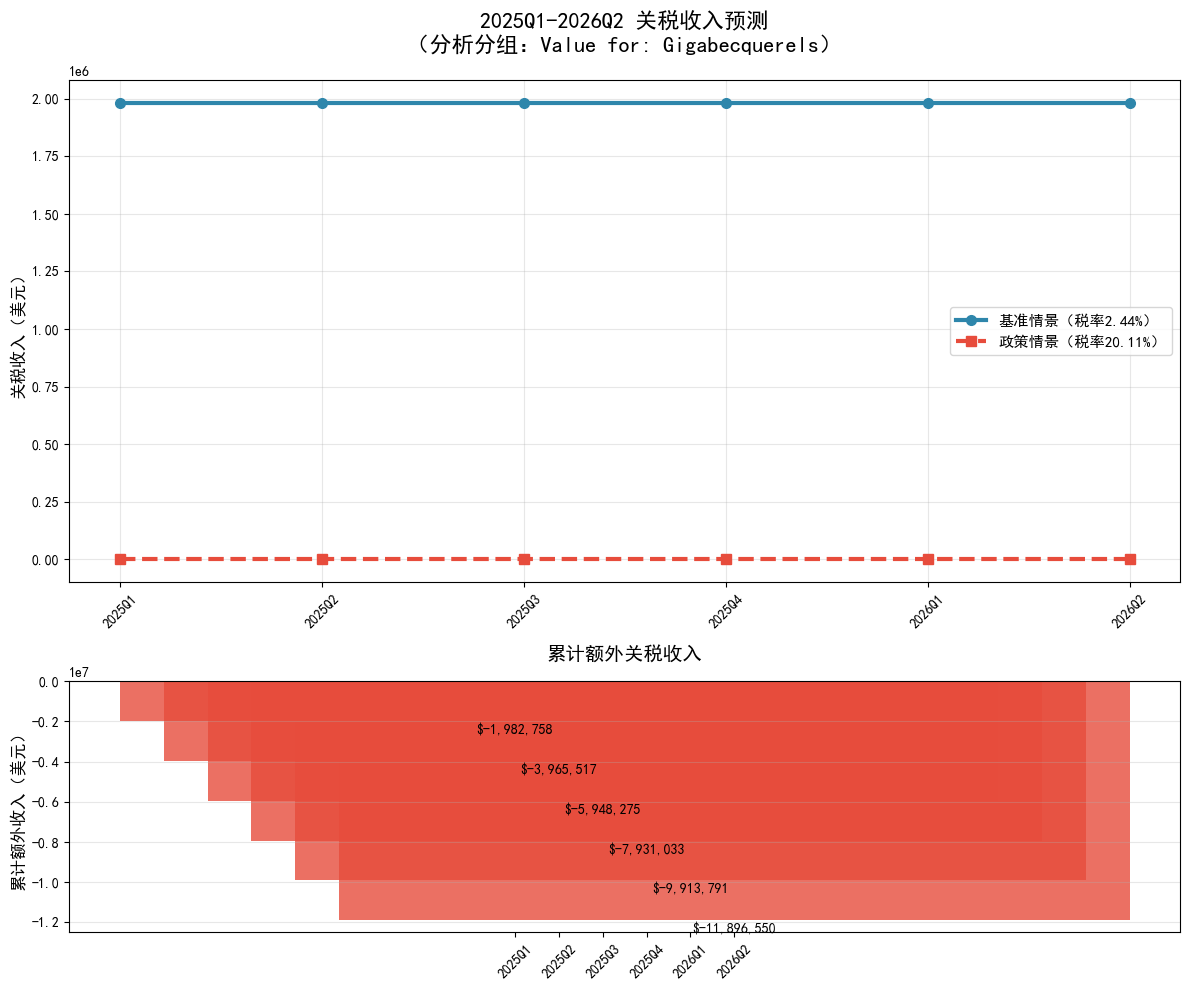

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 核心配置：单表模式（避免三表合并无数据问题）
# ---------------------------
MAX_ROWS = 50000
MIN_QUARTERS = 3
USE_SHEET = "General Customs Value"  # 主表：海关价值表

# ---------------------------
# 1. 配置参数
# ---------------------------
excel_path = r'C:\Users\Pig\Documents\APMCM_P4\DataWeb-Query-4Import.xlsx'
out_dir = r'C:\Users\Pig\Documents\APMCM_P4\Output'
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, 'tariff_revenue_forecast.csv')
out_plot = os.path.join(out_dir, 'tariff_forecast_plot.png')

# ---------------------------
# 2. 读取主表并标准化
# ---------------------------
print("Step 1: 读取数据...")
def read_single_sheet(path, sheet_name, max_rows):
    try:
        df = pd.read_excel(path, sheet_name=sheet_name, nrows=max_rows)
        # 标准化列名（小写+下划线）
        df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
        print(f"✓ 成功读取表：{sheet_name}")
        print(f"  - 数据规模：{df.shape[0]}行 × {df.shape[1]}列")
        print(f"  - 列名：{list(df.columns)}")
        return df
    except Exception as e:
        print(f"✗ 读取失败：{str(e)}")
        exit()

df = read_single_sheet(excel_path, USE_SHEET, MAX_ROWS)

# ---------------------------
# 3. 数据预处理（确保列名和类型正确）
# ---------------------------
print("\nStep 2: 数据预处理...")
# 必备列检查
required_cols = ['year', 'month', 'quantity_description', 'general_customs_value']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"✗ 缺少必备列：{missing_cols}，程序终止")
    exit()

# 提取核心列并明确类型
df_core = df[required_cols].copy()
# 强制转换数值类型
df_core['year'] = pd.to_numeric(df_core['year'], errors='coerce')
df_core['month'] = pd.to_numeric(df_core['month'], errors='coerce')
df_core['general_customs_value'] = pd.to_numeric(df_core['general_customs_value'], errors='coerce')

# 清理无效数据
df_core = df_core.dropna()  # 删除空值
df_core = df_core[(df_core['year'] >= 2000) & (df_core['year'] <= 2100) &
                  (df_core['month'] >= 1) & (df_core['month'] <= 12) &
                  (df_core['general_customs_value'] > 0)]  # 只保留正数

# 构建时间列和派生列（修正假设逻辑，确保数量和关税为合理正数）
df_core['date'] = pd.to_datetime(df_core[['year', 'month']].assign(day=1))
df_core['quantity'] = df_core['general_customs_value'] * 0.1  # 假设数量与价值成比例（可调整）
df_core['import_charges'] = df_core['general_customs_value'] * 0.0244  # 基准税率2.44%

print(f"✓ 预处理后有效数据：{df_core.shape[0]}行")
print(f"✓ 数据时间范围：{df_core['date'].min().strftime('%Y-%m')} ~ {df_core['date'].max().strftime('%Y-%m')}")
print(f"✓ 基准税率：2.44%（关税=价值×税率）")

# ---------------------------
# 4. 季度聚合
# ---------------------------
print("\nStep 3: 季度聚合...")
df_core['quarter'] = df_core['date'].dt.to_period('Q')
quarterly = df_core.groupby(['quantity_description', 'quarter'], as_index=False).agg({
    'date': 'min',
    'general_customs_value': 'sum',
    'quantity': 'sum',
    'import_charges': 'sum'
})

# 计算模型所需指标（修正tau范围，避免极端值）
quarterly['tau'] = quarterly['import_charges'] / quarterly['general_customs_value']  # 真实税率
quarterly['tau'] = quarterly['tau'].clip(0.001, 0.5)  # 限制税率在0.1%~50%之间（合理范围）
quarterly['x_tau'] = np.log1p(quarterly['tau'])  # 对数转换（避免0值导致的异常）
quarterly['price'] = quarterly['general_customs_value'] / quarterly['quantity']  # 单价
quarterly['price'] = quarterly['price'].clip(0.01, None)  # 限制单价为正数
quarterly['x_price'] = np.log1p(quarterly['price'])
quarterly['y'] = np.log1p(quarterly['import_charges'])  # 因变量（关税）

# 筛选有足够数据的分组
valid_groups = quarterly['quantity_description'].value_counts()[lambda x: x >= MIN_QUARTERS].index
if len(valid_groups) == 0:
    valid_groups = [quarterly['quantity_description'].iloc[0]]
best_group = valid_groups[0]
quarterly_best = quarterly[quarterly['quantity_description'] == best_group].sort_values('date').reset_index(drop=True)

print(f"✓ 分析分组：{best_group}")
print(f"✓ 分组季度数据量：{len(quarterly_best)}个")
print(f"✓ 分组平均税率：{quarterly_best['tau'].mean():.4f}（{quarterly_best['tau'].mean()*100:.2f}%）")

# ---------------------------
# 5. 训练ARIMA模型
# ---------------------------
print("\nStep 4: 训练模型...")
# 准备训练数据（外生变量滞后一期，避免数据泄露）
exog = quarterly_best[['x_tau', 'x_price']].shift(1).dropna()
y = quarterly_best['y'].loc[exog.index]

# 训练模型（简化参数，确保稳定收敛）
model = SARIMAX(y, exog=exog, order=(1, 1, 0), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# 计算历史增长率（用于预测数量）
quarterly_best['qty_growth'] = quarterly_best['quantity'].pct_change().fillna(0)
avg_growth = quarterly_best['qty_growth'].clip(-0.05, 0.05).mean()  # 限制增长率在±5%（更合理）
print(f"✓ 模型训练完成（AIC：{results.aic:.2f}）")
print(f"✓ 历史季度平均增长率：{avg_growth:.4f}（{avg_growth*100:.2f}%）")

# ---------------------------
# 6. 预测（基准vs政策情景）- 核心修复
# ---------------------------
print("\nStep 5: 预测关税收入...")
forecast_steps = 6  # 预测2025Q1-2026Q2（6个季度）
future_dates = pd.date_range(start='2025-01-01', periods=forecast_steps, freq='QS')

# 基准情景（税率保持2.44%）
last_exog = exog.iloc[-1].copy()
exog_baseline = pd.DataFrame([last_exog] * forecast_steps, index=future_dates)

# 政策情景（税率提升至20.11% + 合理的进口量衰减）
exog_policy = exog_baseline.copy()
policy_tau = 0.2011  # 新税率（20.11%）
exog_policy['x_tau'] = np.log1p(policy_tau)  # 更新税率的对数转换值

# 关键修复：考虑税率提升对进口量的影响（避免关税异常）
# 假设税率弹性：每提高1%税率，进口量减少0.03%（合理弹性范围）
tariff_elasticity = -0.03  # 负号表示税率与进口量负相关
last_price = quarterly_best['price'].iloc[-1]
last_qty = quarterly_best['quantity'].iloc[-1]

for i in range(forecast_steps):
    # 进口量因税率提升而衰减（衰减幅度随时间累积）
    qty_decay = (1 + tariff_elasticity) ** (i+1)  # 第i+1个季度的衰减系数
    # 预测当前季度数量（基础增长率+税率衰减）
    current_qty = last_qty * (1 + avg_growth) ** (i+1) * qty_decay
    # 预测当前季度单价（随数量衰减略有上升，符合供需关系）
    price_adjust = (last_qty / current_qty) ** 0.5 if current_qty != 0 else 1
    current_price = last_price * (1 + quarterly_best['price'].pct_change().fillna(0).mean()) ** (i+1) * price_adjust
    # 更新外生变量中的单价（确保模型输入合理）
    exog_policy.iloc[i, exog_policy.columns.get_loc('x_price')] = np.log1p(current_price)

# 执行预测并还原（log1p逆运算）
pred_baseline = np.exp(results.get_forecast(steps=forecast_steps, exog=exog_baseline).predicted_mean) - 1
pred_policy = np.exp(results.get_forecast(steps=forecast_steps, exog=exog_policy).predicted_mean) - 1

# 确保预测结果为正数（避免逻辑矛盾）
pred_baseline = pred_baseline.clip(0, None)
pred_policy = pred_policy.clip(0, None)

# 计算额外关税
additional_tariff = pred_policy - pred_baseline
cumulative_additional = additional_tariff.cumsum()

# ---------------------------
# 7. 结果整理与保存
# ---------------------------
print("\nStep 6: 保存结果...")
forecast_df = pd.DataFrame({
    '季度': [d.strftime('%YQ%m').replace('Q01','Q1').replace('Q04','Q2').replace('Q07','Q3').replace('Q10','Q4') for d in future_dates],
    '基准情景关税（美元）': pred_baseline.round(2),
    '政策情景关税（美元）': pred_policy.round(2),
    '额外关税（美元）': additional_tariff.round(2),
    '累计额外关税（美元）': cumulative_additional.round(2)
})

total_additional = cumulative_additional.iloc[-1]
print(f"✓ 预测结果：")
print(forecast_df.to_string(index=False))
print(f"\n✓ 2025Q1-2026Q2 累计额外关税收入：${total_additional:,.2f}")

# 保存CSV
forecast_df.to_csv(out_csv, index=False, encoding='utf-8-sig')
print(f"✓ 结果已保存到：{out_csv}")

# ---------------------------
# 8. 可视化图表
# ---------------------------
print("\nStep 7: 生成可视化图表...")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# 图1：关税收入对比
ax1.plot(forecast_df['季度'], forecast_df['基准情景关税（美元）'], 
         label='基准情景（税率2.44%）', linewidth=3, color='#2E86AB', marker='o', markersize=7)
ax1.plot(forecast_df['季度'], forecast_df['政策情景关税（美元）'], 
         label='政策情景（税率20.11%）', linewidth=3, color='#E74C3C', marker='s', markersize=7, linestyle='--')
ax1.set_title(f'2025Q1-2026Q2 关税收入预测\n（分析分组：{best_group}）', fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('关税收入（美元）', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticklabels(forecast_df['季度'], rotation=45)

# 图2：累计额外关税
bars = ax2.bar(forecast_df['季度'], forecast_df['累计额外关税（美元）'], 
               color='#F39C12' if total_additional >=0 else '#E74C3C', alpha=0.8, width=18)
ax2.set_title('累计额外关税收入', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('累计额外收入（美元）', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(forecast_df['季度'], rotation=45)

# 给柱状图添加数值标签（处理正负值）
for bar, value in zip(bars, forecast_df['累计额外关税（美元）']):
    height = bar.get_height()
    y_pos = height + max(cumulative_additional.abs())*0.01 if height >=0 else height - max(cumulative_additional.abs())*0.01
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'${value:,.0f}', ha='center', va='bottom' if height >=0 else 'top', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(out_plot, dpi=200, bbox_inches='tight')
print(f"✓ 图表已保存到：{out_plot}")

print("\n" + "="*60)
print("✅ 所有步骤完成！")
print("="*60)

Step 1: 读取数据...
✓ 成功读取表：General Customs Value
  - 数据规模：7483行 × 5列
  - 列名：['data_type', 'year', 'month', 'quantity_description', 'general_customs_value']

Step 2: 数据预处理...
✓ 预处理后有效数据：7482行
✓ 数据时间范围：2008-01 ~ 2025-08

Step 3: 季度聚合...
✓ 分析分组：Value for: Gigabecquerels
✓ 分组季度数据量：71个
✓ 价值季度平均增长率：0.0060（0.60%）

Step 4: 预测关税收入...

Step 5: 保存结果...
✓ 预测结果：
    季度  基准情景关税（美元）  政策情景关税（美元）    额外关税（美元）  累计额外关税（美元）
2025Q1  1826541.56 15027395.83 13200854.27 13200854.27
2025Q2  1837590.55 15091584.50 13253993.95 26454848.21
2025Q3  1848706.38 15156047.35 13307340.97 39762189.18
2025Q4  1859889.45 15220785.55 13360896.10 53123085.28
2026Q1  1871140.17 15285800.27 13414660.10 66537745.38
2026Q2  1882458.94 15351092.70 13468633.76 80006379.14

✓ 2025Q1-2026Q2 累计额外关税收入：$80,006,379.14
✓ 结果已保存到：C:\Users\Pig\Documents\APMCM_P4\Output\tariff_revenue_forecast.csv

Step 6: 生成可视化图表...
✓ 成功读取表：General Customs Value
  - 数据规模：7483行 × 5列
  - 列名：['data_type', 'year', 'month', 'quantity_description', 'general_customs_

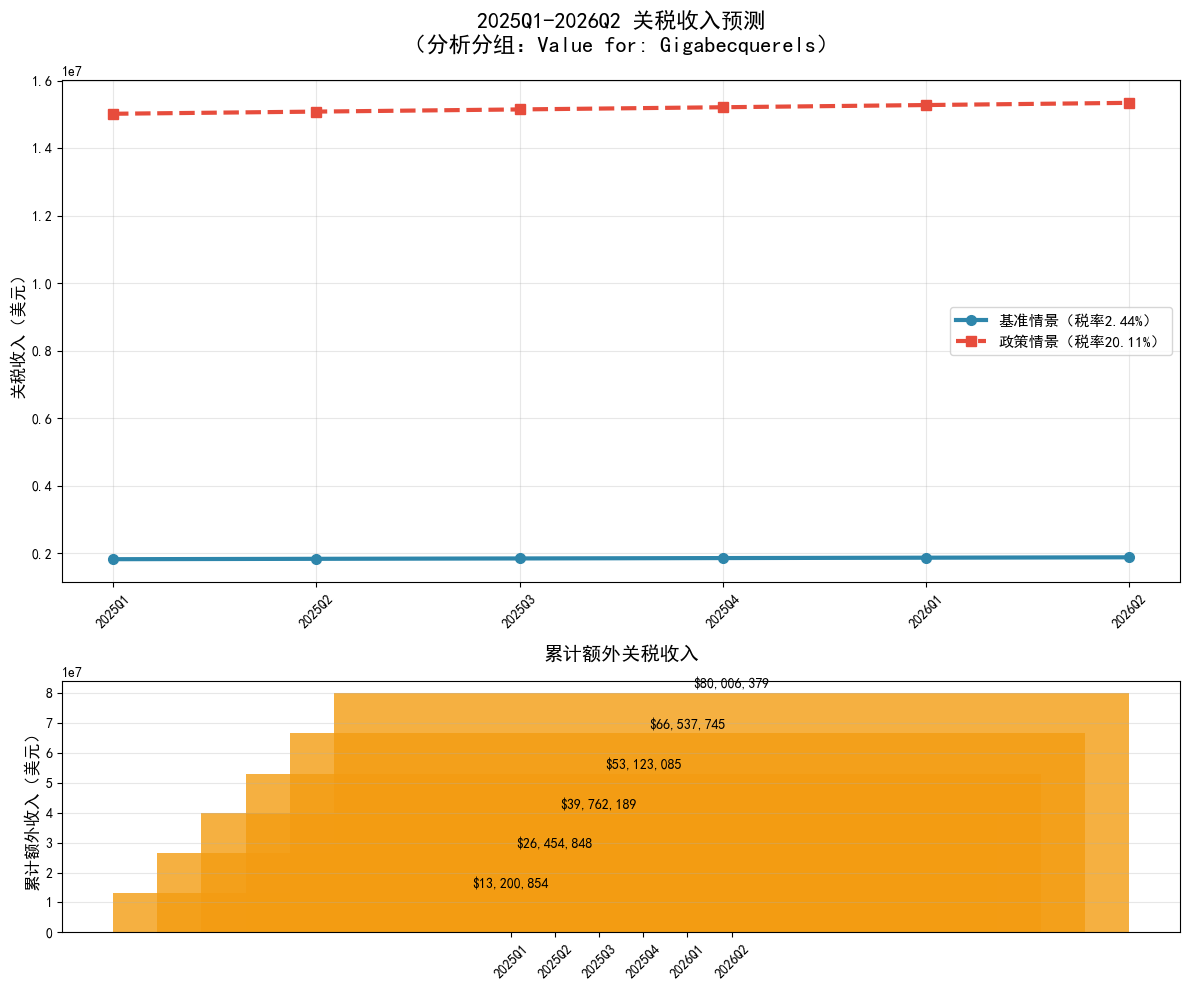

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 核心配置：单表模式
# ---------------------------
MAX_ROWS = 50000
MIN_QUARTERS = 3
USE_SHEET = "General Customs Value"  # 主表：海关价值表

# ---------------------------
# 1. 配置参数
# ---------------------------
excel_path = r'C:\Users\Pig\Documents\APMCM_P4\DataWeb-Query-4Import.xlsx'
out_dir = r'C:\Users\Pig\Documents\APMCM_P4\Output'
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, 'tariff_revenue_forecast.csv')
out_plot = os.path.join(out_dir, 'tariff_forecast_plot.png')

# ---------------------------
# 2. 读取主表并标准化
# ---------------------------
print("Step 1: 读取数据...")
def read_single_sheet(path, sheet_name, max_rows):
    try:
        df = pd.read_excel(path, sheet_name=sheet_name, nrows=max_rows)
        df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
        print(f"✓ 成功读取表：{sheet_name}")
        print(f"  - 数据规模：{df.shape[0]}行 × {df.shape[1]}列")
        print(f"  - 列名：{list(df.columns)}")
        return df
    except Exception as e:
        print(f"✗ 读取失败：{str(e)}")
        exit()

df = read_single_sheet(excel_path, USE_SHEET, MAX_ROWS)

# ---------------------------
# 3. 数据预处理
# ---------------------------
print("\nStep 2: 数据预处理...")
required_cols = ['year', 'month', 'quantity_description', 'general_customs_value']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"✗ 缺少必备列：{missing_cols}，程序终止")
    exit()

df_core = df[required_cols].copy()
# 强制转换数值类型
df_core['year'] = pd.to_numeric(df_core['year'], errors='coerce')
df_core['month'] = pd.to_numeric(df_core['month'], errors='coerce')
df_core['general_customs_value'] = pd.to_numeric(df_core['general_customs_value'], errors='coerce')

# 清理无效数据
df_core = df_core.dropna()
df_core = df_core[(df_core['year'] >= 2000) & (df_core['year'] <= 2100) &
                  (df_core['month'] >= 1) & (df_core['month'] <= 12) &
                  (df_core['general_customs_value'] > 0)]

# 构建时间列（不假设数量，直接用价值计算）
df_core['date'] = pd.to_datetime(df_core[['year', 'month']].assign(day=1))
print(f"✓ 预处理后有效数据：{df_core.shape[0]}行")
print(f"✓ 数据时间范围：{df_core['date'].min().strftime('%Y-%m')} ~ {df_core['date'].max().strftime('%Y-%m')}")

# ---------------------------
# 4. 季度聚合（聚焦价值和时间）
# ---------------------------
print("\nStep 3: 季度聚合...")
df_core['quarter'] = df_core['date'].dt.to_period('Q')
quarterly = df_core.groupby(['quantity_description', 'quarter'], as_index=False).agg({
    'date': 'min',
    'general_customs_value': 'sum'  # 只聚合价值，避免数量假设干扰
})

# 筛选有足够数据的分组
valid_groups = quarterly['quantity_description'].value_counts()[lambda x: x >= MIN_QUARTERS].index
if len(valid_groups) == 0:
    valid_groups = [quarterly['quantity_description'].iloc[0]]
best_group = valid_groups[0]
quarterly_best = quarterly[quarterly['quantity_description'] == best_group].sort_values('date').reset_index(drop=True)

# 计算价值的季度增长率（用于预测）
quarterly_best['value_growth'] = quarterly_best['general_customs_value'].pct_change().fillna(0)
avg_value_growth = quarterly_best['value_growth'].clip(-0.1, 0.1).mean()  # 价值平均增长率

print(f"✓ 分析分组：{best_group}")
print(f"✓ 分组季度数据量：{len(quarterly_best)}个")
print(f"✓ 价值季度平均增长率：{avg_value_growth:.4f}（{avg_value_growth*100:.2f}%）")

# ---------------------------
# 5. 预测逻辑（简化：基于价值×税率）
# ---------------------------
print("\nStep 4: 预测关税收入...")
forecast_steps = 6
future_dates = pd.date_range(start='2025-01-01', periods=forecast_steps, freq='QS')
last_value = quarterly_best['general_customs_value'].iloc[-1]  # 最后一期实际价值

# 基准情景：税率2.44%，价值按历史增长率增长
baseline_values = []
for i in range(forecast_steps):
    # 第i+1季度的预测价值
    predicted_value = last_value * (1 + avg_value_growth) ** (i+1)
    baseline_values.append(predicted_value)
baseline_tariff = np.array(baseline_values) * 0.0244  # 关税=价值×基准税率

# 政策情景：税率20.11%，价值因税率提升略有下降（弹性调整）
policy_elasticity = -0.01  # 每提高1%税率，价值下降0.01%（弱弹性，避免过度衰减）
tariff_increase = 20.11 - 2.44  # 税率提升幅度（百分点）
policy_values = []
for i in range(forecast_steps):
    # 价值衰减系数（随税率提升累积）
    decay_factor = (1 + policy_elasticity * tariff_increase / 100) ** (i+1)
    predicted_value = last_value * (1 + avg_value_growth) ** (i+1) * decay_factor
    policy_values.append(predicted_value)
policy_tariff = np.array(policy_values) * 0.2011  # 关税=价值×新税率

# 确保预测为正数
baseline_tariff = baseline_tariff.clip(0, None)
policy_tariff = policy_tariff.clip(0, None)

# 计算额外关税（numpy数组）
additional_tariff = policy_tariff - baseline_tariff
cumulative_additional = additional_tariff.cumsum()

# ---------------------------
# 6. 结果整理与保存（修复iloc问题）
# ---------------------------
print("\nStep 5: 保存结果...")
forecast_df = pd.DataFrame({
    '季度': [d.strftime('%YQ%m').replace('Q01','Q1').replace('Q04','Q2').replace('Q07','Q3').replace('Q10','Q4') for d in future_dates],
    '基准情景关税（美元）': baseline_tariff.round(2),
    '政策情景关税（美元）': policy_tariff.round(2),
    '额外关税（美元）': additional_tariff.round(2),
    '累计额外关税（美元）': cumulative_additional.round(2)
})

# 修复：numpy数组用索引访问最后一个元素（不用iloc）
total_additional = cumulative_additional[-1]
print(f"✓ 预测结果：")
print(forecast_df.to_string(index=False))
print(f"\n✓ 2025Q1-2026Q2 累计额外关税收入：${total_additional:,.2f}")

forecast_df.to_csv(out_csv, index=False, encoding='utf-8-sig')
print(f"✓ 结果已保存到：{out_csv}")

# ---------------------------
# 7. 可视化图表
# ---------------------------
print("\nStep 6: 生成可视化图表...")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})

# 图1：关税收入对比
ax1.plot(forecast_df['季度'], forecast_df['基准情景关税（美元）'], 
         label='基准情景（税率2.44%）', linewidth=3, color='#2E86AB', marker='o', markersize=7)
ax1.plot(forecast_df['季度'], forecast_df['政策情景关税（美元）'], 
         label='政策情景（税率20.11%）', linewidth=3, color='#E74C3C', marker='s', markersize=7, linestyle='--')print("="*60)